# 1. Introducción teórica sobre SVM con ejemplos
En esta práctica vamos a clasificar en dos clases los datos proporcionados en ciertos conjuntos de datos haciendo uso del algoritmo de **Support Vector Machines** (SVM). Trabajaremos con conjuntos que tienen dos variables *features*, **$x_1, x_2$**, y una variable objetivo (también llamada *target* o *label*) binaria, **$y$**, es decir, que toma dos valores posibles, 1 ó -1.  
El primer conjunto de datos que se va a estudiar es separable linealmente. Tiene la estructura mostrada en la siguiente figura.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm
from __future__ import division
plt.style.use("ggplot")

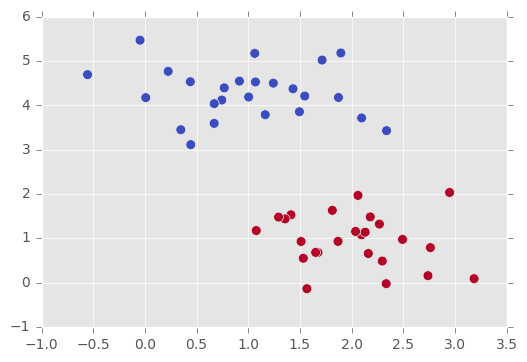

In [551]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')

Un modelo clasificador basado en SVM va a intentar trazar una línea que separe las dos clases de puntos, pero la cuestión que surge es qué línea dibujar, porque hay infinidad de posibilidades que separan correctamente las dos clases de datos. Por ejemplo:

(-1, 3.5)

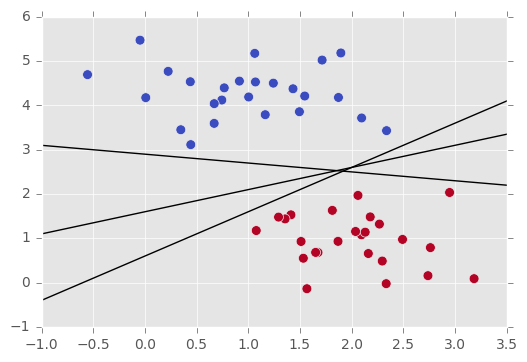

In [677]:
xfit = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plt.hold(True)

for m, b in [(1, 0.6), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, 'k-')
    plt.hold(True)

plt.xlim(-1, 3.5)


Cualquiera de los tres clasificadores de ejemplo separa correctamente las dos clases. Pero, dependiendo de cuál se elija, los puntos nuevos que se introduzcan en el conjunto de datos se clasificarán de forma muy diferente. Lo que hacen las SVM no es considerar solo la línea, sino toda una banda de cierta anchura en torno a la línea:

(-1, 6)

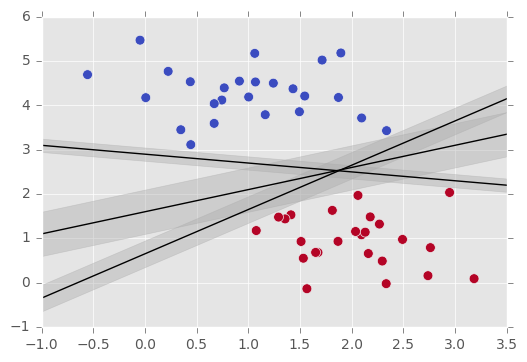

In [678]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plt.hold(True)

for m, b, d in [(1, 0.65, 0.3), (0.5, 1.6, 0.5), (-0.2, 2.9, 0.15)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.hold(True)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)
    plt.hold(True)
    
plt.xlim(-1, 3.5)
plt.ylim(-1,6)

**Las SVM maximizan esta anchura** para que así, al incluir nuevos puntos, la probabilidad de que caigan en la clase correcta sea mayor. Si se eligiera un margen más estrecho, los nuevos puntos podrían caer en el lado equivocado y, por consiguiente, ser mal clasificados con mayor facilidad. Por tanto, la banda de enmedio es la mejor elección en este ejemplo: 

In [679]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [680]:
def hiperplanos(clf, ax=None):
    
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # márgenes
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

(-1, 6)

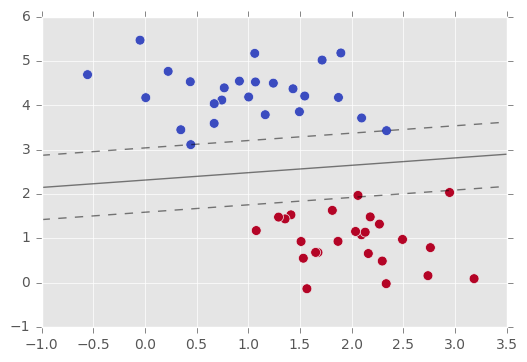

In [682]:
import warnings
warnings.filterwarnings("ignore")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
hiperplanos(clf)
plt.xlim(-1, 3.5)
plt.ylim(-1,6)

Los puntos que tocan las líneas discontinuas (llamadas hiperplanos de soporte) son los vectores de soporte, que son los puntos más importantes porque son los que determinan los hiperplanos.

Para hallar la anchura de la banda encerrada por las dos líneas discontinuas se necesita obtener previamente la distancia de un punto a una recta. En un espacio bidimensional (que es en el que vamos a trabajar en esta práctica), la distancia de un punto $P(a,b)$ a una recta $r$ de ecuación explícita $y=mx+n$ se puede calcular de la siguiente forma (véase la figura).

![Distancia](./Practica_AlgoritmosAvanzados_Pablo/DistanciaPuntoRecta.png)

Se entiende que la distancia de una recta $r$ a un punto $P$ exterior a ella es la que se mide sobre la línea perpendicular a la recta que pasa por el punto exterior (trazo rojo discontinuo). Si se reescribe la ecuación de la recta pasando todos los términos al mismo miembro de la ecuación, se obtiene la ecuación implícita (o ecuación general): $Ax+By+C=0.$ Un vector director de la recta $r$ es $\vec{v}=(-B,A)$ y un vector director de una recta perpendicular a ella puede obtenerse invirtiendo el orden de sus componentes y cambiando el signo de una de ellas, esto es, $\vec{n}=(A,B)$, ya que su producto escalar debe ser cero al ser ortogonales: $(-B,A)\cdot(A,B)=-BA+AB=0.$  
Es fácil obtener un punto $R(x_0,y_0)$ de la recta $r$ sin más que sustituir un valor cualquiera de la variable $x$ en la ecuación de la recta y despejar la $y.$ Lo que no es tan fácil es que dicho punto sea justamente la intersección de la recta $r$ con su perpendicular que pasa por $P$ (si fuera así, sería inmediato deducir ya la distancia). En general, el punto $R$ obtenido estará en una posición cualquiera como en la figura. El producto escalar del vector $\vec{RP}$ y el vector $\vec{n}$ perpendicular a la recta $r$ es $\vec{RP}\cdot\vec{n}=|\vec{RP}|\cdot|\vec{n}|\cdot\cos(\theta),$ donde $\theta$ es el ángulo formado por ambos vectores $\vec{RP}$ y $\vec{n}$ (azul y verde). La distancia buscada es precisamente el (módulo del) producto $|\vec{RP}|\cdot\cos(\theta).$ Por tanto,

\begin{equation}d(P,r)= \left|\frac{\vec{RP}\cdot\vec{n}}{|\vec{n}|}\right|=\left|\frac{(a-x_0,b-y_0)\cdot(A,B)}{\sqrt{A^2+B^2}}\right|=\frac{\left|aA+bB-(x_0A+y_0B)\right|}{\sqrt{A^2+B^2}}=\frac{\left|aA+bB+C\right|}{\sqrt{A^2+B^2}},\end{equation}

ya que el punto $R(x_0,y_0)$ pertenece a la recta $r$ y, por tanto, sus coordenadas deben verificar su ecuación: $Ax_0+By_0+C=0.$

Siguiendo la notación habitual, a las variables *features*, en lugar de denotarlas como $x, y,$ se van a expresar como $x_1, x_2$ y a los coeficientes de la ecuación de la recta, en vez de llamarlos $A, B, C,$ se van a denotar como $w_1, w_2, b.$ De manera que la ecuación de la recta que se pretende hallar (es decir, del clasificador lineal llamado hiperplano de decisión, representado por la línea sólida dos figuras más atrás) se escribirá como $w_1x_1+w_2x_2+b=0,$ en vez de $Ax+By+C=0.$  
Como líneas discontinuas se toman dos paralelas (hiperplanos de soporte) a la línea sólida y equidistantes a ella. Nótese que los coeficientes de las variables tienen que ser iguales en las tres ecuaciones porque están relacionados con la pendiente y las tres rectas son paralelas; solo cambian los términos independientes. Como las líneas discontinuas equidistan de la línea sólida, sus términos independientes son iguales al término independiente de la línea sólida más/menos una misma cantidad. Por simplicidad, en un primer momento se escoge el valor 1 como dicha cantidad, esto es, se eligen las dos rectas que tienen por ecuaciones $w_1x_1+w_2x_2+b=1$ y $w_1x_1+w_2x_2+b=-1.$ Esta elección implica tener una banda de anchura fija (*hard margin*). Posteriormente se introducen unas cantidades que permiten mayor flexibilidad en la anchura del margen de separación (*soft margin*).

Ahora es cuando se utiliza la expresión de la distancia de un punto a una recta que se ha deducido previamente. Para obtener la anchura del margen de separación de las dos clases de puntos se necesita calcular la distancia de cada línea discontinua a la línea sólida. Para ello basta con hallar la distancia a la línea sólida de un punto situado sobre cada línea discontinua. Sea $P(a_1,a_2)$ un punto de la línea discontinua que tiene por ecuación $w_1x_1+w_2x_2+b=1.$ Su distancia $d$ a la línea sólida es, entonces,

\begin{equation}d=\frac{\left|a_1w_1+a_2w_2+b\right|}{\sqrt{w_1^2+w_2^2}}.\end{equation}

Evidentemente, las coordenadas del punto $P$ deben verificar la ecuación de la recta a la que pertenece, $w_1a_1+w_2a_2+b=1,$ de manera que el numerador de la expresión de la distancia $d$ es simplemente 1 y queda:

\begin{equation}d=\frac{1}{\sqrt{w_1^2+w_2^2}}.\end{equation}

Lo mismo sucede para la distancia $d'$ a la línea sólida de un punto $P'(a'_1,a'_2)$ situado sobre la otra línea discontinua:

\begin{equation}d'=\frac{\left|a'_1w_1+a'_2w_2+b\right|}{\sqrt{w_1^2+w_2^2}}=\frac{|-1|}{\sqrt{w_1^2+w_2^2}}=\frac{1}{\sqrt{w_1^2+w_2^2}}.\end{equation}

Por tanto, la anchura del margen buscada es la suma de ambas distancias:

\begin{equation}d+d'=\frac{2}{\sqrt{w_1^2+w_2^2}}=\frac{2}{\|\mathbf{w}\|}.\end{equation}

Como la expresión de la anchura tiene forma de fracción con numerador constante, para maximizarla hay que minimizar el denominador, es decir, la raíz cuadrada. Para miminizar una raíz cuadrada basta con minimizar su radicando. Entonces, la cantidad a minimizar en los problemas de clasificación con SVM es sencillamente

\begin{equation}w_1^2+w_2^2=\|\mathbf{w}\|^2.\end{equation}

Suele añadirse un factor $1/2$ a esta cantidad para simplificar el factor 2 que surge al derivar en el proceso de optimización.

Si, en lugar de dos *features*, el conjunto de datos incluyera tres, el separador lineal buscado no sería una recta en un plano, sino un plano en un espacio de tres dimensiones que tendría una ecuación general del tipo $w_1x_1+w_2x_2+w_3x_3+b=0$ y los hiperplanos de soporte (equivalentes a las líneas discontinuas del caso bidimensional) serían dos planos paralelos y equidistantes a aquel con ecuaciones $w_1x_1+w_2x_2+w_3x_3+b=1$ y $w_1x_1+w_2x_2+w_3x_3+b=-1.$ Para hallar la anchura del margen de separación entre las dos clases de puntos habría que obtener la distancia al hiperplano de decisión de un punto de cada hiperplano de soporte. El procedimiento para deducir la distancia de un punto $P(a,b,c)$ a un plano $\pi$ de ecuación $w_1x_1+w_2x_2+w_3x_3+b=0$ es análogo al seguido antes para la distancia de un punto a una recta. Se escoge un punto cualquiera del plano, $R(x_0,y_0,z_0),$ y se multiplica escalarmente el vector $\vec{RP}$ por un vector normal al plano, que tiene como componentes los coeficientes del plano, $\vec{n}=(w_1,w_2,w_3).$ Este producto es $\vec{RP}\cdot\vec{n}=|\vec{RP}|\cdot|\vec{n}|\cdot\cos(\theta),$ donde la distancia buscada es precisamente el (módulo del) producto $|\vec{RP}|\cdot\cos(\theta).$ Por tanto,

\begin{equation}d(P,\pi)= \left|\frac{\vec{RP}\cdot\vec{n}}{|\vec{n}|}\right|=\left|\frac{(a-x_0,b-y_0,c-z_0)\cdot(w_1,w_2,w_3)}{\sqrt{w_1^2+w_2^2+w_3^2}}\right|=\frac{\left|aw_1+bw_2+cw_3-(x_0w_1+y_0w_2+z_0w_3)\right|}{\sqrt{w_1^2+w_2^2+w_3^2}}=\frac{1}{\sqrt{w_1^2+w_2^2+w_3^2}},\end{equation}

ya que, por un lado, el punto $R(x_0,y_0,z_0)$ pertenece al plano $\pi$ y, por tanto, sus coordenadas deben verificar su ecuación: $w_1x_0+w_2y_0+w_3z_0+b=0$ y, por otro lado, el punto $P$ pertenece a uno de los dos hiperplanos de soporte y, entonces, sus coordenadas satisfacen $w_1a+w_2b+w_3c+b=\pm 1.$ La anchura del margen, que es el doble de dicha distancia, queda

\begin{equation}\frac{2}{\sqrt{w_1^2+w_2^2+w_3^2}}=\frac{2}{\|\mathbf{w}\|}.\end{equation}

Y si, en lugar de tres *features*, el *dataset* incluyera cuatro o más, la ecuación del hiperplano de decisión (que ya no tendría interpretación geométrica) incluiría más coeficientes y variables: $w_1x_1+w_2x_2+w_3x_3+w_4x_4+\cdots+b=0,$ pero el procedimiento sería análogo a los anteriores y se llegaría a que la cantidad a minimizar tiene la misma expresión en todos los casos, independientemente del número de dimensiones (de *features*) del problema, esto es $\|\mathbf{w}\|^2.$

Puesto que hay que maximizar la anchura entre las clases de puntos, entra en juego la **teoría de optimización**. Para buscar los máximos y mínimos de una función (llamada función objetivo) de una sola variable real, $f(x)$, hay que buscarlos entre los puntos que anulen su derivada porque si una función toma un valor extremo (máximo o mínimo) en $x=x^*$, se cumple que $\left.\frac{df}{dx}\right|_{x^*}=0$. Si la función tiene varias variables, $f(x_1, x_2,\ldots, x_n)$, todas sus derivadas parciales se anulan en los puntos extremos,

\begin{equation}\left.\frac{\partial f}{\partial x_1}\right|_{\mathbf{x^*}}=0, \left.\frac{\partial f}{\partial x_2}\right|_{\mathbf{x^*}}=0,\ldots, \left.\frac{\partial f}{\partial x_n}\right|_{\mathbf{x^*}}=0,\end{equation}

o dicho de otro modo, su gradiente (formado por todas las derivadas parciales) debe anularse, **$\nabla f(x^*)=0.$**  
Esto se deduce del hecho de que el diferencial de la función debe anularse en el extremo, 

\begin{equation}df=\left.\frac{\partial f}{\partial x_1}\right|_{\mathbf{x^*}} dx_1 + \left.\frac{\partial f}{\partial x_2}\right|_{\mathbf{x^*}} dx_2 +\ldots+ \left.\frac{\partial f}{\partial x_n}\right|_{\mathbf{x^*}} dx_n=0.\end{equation} 

Como todas las variables $x_1, x_2,\ldots, x_n$ son independientes, también lo serán sus variaciones $dx_1, dx_2,\ldots, dx_n,$ y la única manera de que se cumpla la condición $df=0$ para cualesquier valores de $dx_1, dx_2,\ldots, dx_n$ es que todos los coeficientes $\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2},\ldots,\frac{\partial f}{\partial x_n}$ sean nulos en el valor extremo de la función.  
Hasta aquí es a grandes rasgos la teoría para funciones que no presentan ninguna restricción en su dominio. Pero, ¿qué ocurre para funciones con restricciones? Supongamos que se quiere minimizar (o maximizar) una función objetivo de $n$ variables que presenta $p$ restricciones de igualdad:

In [775]:
%%latex
\begin{eqnarray}\min_{\begin{subarray}{l}\mathbf{x}\end{subarray}}&\;\;& f(\mathbf{x})\\
              \mbox{subject to}&\;\;& h_j(\mathbf{x})=0 \;\;\; \forall\, j = 1, 2,\ldots, p \end{eqnarray}

<IPython.core.display.Latex object>

En este caso las variables $x_1, x_2,\ldots, x_n$ no son todas independientes, sino que entre ellas existen $p$ relaciones de condición $h_j(\mathbf{x})=0.$ Por tanto, $n-p$ de estas variables podrán tomar valores independientes, pero $p$ de ellas dependerán de los valores de las demás de acuerdo con estas relaciones $h_j(\mathbf{x})=0.$ Como las funciones $h_j$ son idénticamente cero, se cumple que $\frac{\partial h_j}{\partial x_1} dx_1 + \frac{\partial h_j}{\partial x_2} dx_2 +\ldots+ \frac{\partial h_j}{\partial x_n}dx_n=0\;\; \forall \, j=1, 2,\ldots,p$ en el extremo (además de cumplirse $df=0,$ claro).  Multipliquemos cada ecuación anterior por una cantidad arbitraria $\lambda_j$ (llamada **multiplicador indeterminado de Lagrange**) y sumémoslas a $df=0.$ Se verifica

\begin{equation}\sum_{i=1}^n\left(\frac{\partial f}{\partial x_i}+\sum_{j=1}^p \lambda_j \frac{\partial h_j}{\partial x_i}\right)dx_i =0.\end{equation}

Ahora ya no ocurre lo mismo que en el caso sin restricciones: los $n$ paréntesis anteriores (los coeficientes de los diferenciales $dx_i$) no tienen por qué anularse puesto que ahora hay $p$ diferenciales que dependen de los valores de los $n-p$ restantes. Pero, si se eligen los multiplicadores de Lagrange $\lambda_1,\lambda_2,\ldots,\lambda_p$ de forma que se cumpla

\begin{equation}\frac{\partial f}{\partial x_i}+\sum_{j=1}^p \lambda_j \frac{\partial h_j}{\partial x_i}=0 \;\;\forall i=1,2,\ldots,p\end{equation}

en el valor extremo de la función objetivo, se eliminan estos sumandos de la ecuación anterior, y para que esta se cumpla para cualquier valor arbitrario de los diferenciales restantes $dx_{p+1},dx_{p+2},\ldots,dx_{n}$, debe satisfacerse que

\begin{equation}\frac{\partial f}{\partial x_i}+\sum_{j=1}^p \lambda_j \frac{\partial h_j}{\partial x_i}=0 \;\;\forall i=p+1,p+2,\ldots,n.\end{equation}

Por tanto, debe cumplirse que todos los coeficientes sean nulos.  
Resumiendo, la introducción de estas cantidades arbitrarias $\lambda_j$ nos permite ajustar las ecuaciones a nuestro gusto para poder asegurar que los coeficientes de los diferenciales se anulen en el extremo de la función objetivo $f.$ Este procedimiento es válido porque todas las expresiones añadidas al análisis, que multiplican a dichas cantidades, son nulas en el extremo de la función objetivo y, entonces, se recupera dicho extremo, que es la meta del problema de optimización.  
Otro modo de interpretar los multiplicadores de Lagrange consiste en considerarlos como nuevas variables de una nueva función $L$, llamada **función lagrangiana**, que tiene como dominio un espacio ampliado, de manera que pasamos de estudiar los extremos de la función $f:\mathbf{R^n}\rightarrow\mathbf{R}$ a estudiar los de la función $L:\mathbf{R^n}\times\mathbf{R^p}\rightarrow\mathbf{R},$ definida como $L(\mathbf{x,\lambda})=f(\mathbf{x})+\sum_{j=1}^p\lambda_j h_j(\mathbf{x}).$ En el extremo se cumple que $L(\mathbf{x^*,\lambda^*})=f(\mathbf{x^*})$ puesto que $h_j(\mathbf{x^*})=0$ y, entonces, el extremo de $L$ coincide con el extremo de $f,$ que es el que se pretende hallar.

Esta descripción es válida para problemas de optimización de funciones que incluyen restricciones de igualdad, pero ¿cómo será para problemas con restricciones de desigualdad también? Ahora el planteamiento del problema es:

In [774]:
%%latex
\begin{eqnarray} \min_{\begin{subarray}{l}\mathbf{x}\end{subarray}}&\;\;& f(\mathbf{x})\\

              \mbox{subject to}&\;\;& g_i(\mathbf{x})\leq 0 \;\;\; \forall\, i = 1, 2,\ldots, m\\
                               &\;\;&h_j(\mathbf{x})=0 \;\;\; \forall\, j = 1, 2,\ldots, p\end{eqnarray}

<IPython.core.display.Latex object>

En este caso la función lagrangiana es $L:\mathbf{R^n}\times\mathbf{R^m}\times\mathbf{R^p}\rightarrow\mathbf{R},$ definida como $L(\mathbf{x,\alpha,\beta})=f(\mathbf{x})+\sum_{i=1}^n\alpha_i g_i(\mathbf{x})+\sum_{j=1}^p\beta h_j(\mathbf{x}),$ donde $\alpha_i$ y $\beta_j$ son los multiplicadores de Lagrange de las condiciones de desigualdad e igualdad, respectivamente.  
Los problemas en los que nos vamos a centrar son casos de **programación convexa**, en los que tanto la función objetivo $f$ como las de restricción $g_i, h_j$ son convexas, así como sus dominios. Además, estas funciones son diferenciables en el mínimo $\mathbf{x^*}.$ Bajo estas circunstancias se satisfacen las condiciones de **Karush-Kuhn-Tucker (KKT)**:  

\begin{eqnarray}\nabla L(\mathbf{x^*,\alpha^*, \beta^*})=\nabla f(\mathbf{x^*})+\sum_{i=1}^n\alpha_i^* \nabla g_i(\mathbf{x^*})+\sum_{j=1}^p\beta_j^* \nabla h_j^*(\mathbf{x^*})=0,\\
g_i(x^*)\leq 0\;\; \forall i=1,\ldots,m,\\
h_j(x^*)=0\;\;\forall j=1,\ldots,p,\\
\alpha_i^*\geq 0\;\; \forall i=1,\ldots,m,\\
\alpha_i^* g_i(x^*)= 0\;\; \forall i=1,\ldots,m.\end{eqnarray}

Esta forma de plantear el problema se llama **problema primal**. Se puede reformular el problema de otra manera. La **función dual de Lagrange** es el mínimo de la función lagrangiana respecto a $\mathbf{x}:$ $\Theta(\mathbf{\alpha,\beta})\equiv\min_{x}L(\mathbf{x,\alpha,\beta}).$ Se cumple que la función dual es siempre cota inferior de $f(\mathbf{x}).$ En particular, también en el extremo: $\Theta(\mathbf{\alpha,\beta})\leq f(\mathbf{x^*}).$ Entonces, lo que interesa es hallar la mayor cota inferior de $f,$ es decir, maximizar la función dual:

\begin{eqnarray} \max_{\begin{subarray}{l}\mathbf{\alpha,\beta}\end{subarray}}&\;\;& \Theta(\mathbf{\alpha,\beta})\\
              \mbox{subject to}&\;\;& \alpha_i\geq 0 \;\;\; \forall\, i = 1, 2,\ldots, m
                               \end{eqnarray}
                               
De esta forma hemos transformado un problema de minimización con restricciones en uno con menos restricciones, llamado **problema dual**. Este procedimiento se denomina relajación lagrangiana.

## Ejemplo

In [772]:
%%latex
\begin{eqnarray} \min_{\begin{subarray}{l}x,y\end{subarray}}&\;\;& f(x,y)=9y+(x-5)^2\\

              \mbox{subject to}&\;\;& g_1(x,y)=x^2+y\leq 0,\\
                               &\;\;& g_2(x,y)=-x-y\leq 0,\\
                               &\;\;& g_3(x,y)=x+1\leq 0.\end{eqnarray}

<IPython.core.display.Latex object>

En primer lugar demuestro que se trata de un problema convexo. Para ello calculo la hessiana de la función objetivo:                                               

In [761]:
%%latex
\begin{equation}\nabla^2 f(x,y)\equiv H_f(x,y)=\left(\begin{matrix}
                                                 \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x\partial y}\\
                                                 \frac{\partial^2 f}{\partial y\partial x} & \frac{\partial^2 f}{\partial y^2}
                                               \end{matrix}\right)=
                                               \left(\begin{matrix}
                                                  2 & 0\\
                                                  0 & 0
                                               \end{matrix}\right) \end{equation}

<IPython.core.display.Latex object>

Esta matriz es semidefinida positiva porque todos los determinantes de
orden $1,2,\ldots,n$ (siendo n la dimensión de la matriz) obtenidos añadiendo filas y
columnas consecutivas desde el primer elemento son mayores o iguales que cero:



\begin{equation}|2|=2\geq0,\;\;\;\; \left|\begin{matrix}
                                                  2 & 0\\
                                                  0 & 0
                                               \end{matrix}\right|=0\geq0. \end{equation}

Lo mismo ocurre con la hessiana de la función de restricción $g_1:$

In [762]:
%%latex
\begin{equation}\nabla^2 g_1(x,y)\equiv H_{g_1}(x,y)=\left(\begin{matrix}
                                             \frac{\partial^2 g_1}{\partial x^2} & \frac{\partial^2 g_1}{\partial x\partial y}\\
                                             \frac{\partial^2 g_1}{\partial y\partial x} & \frac{\partial^2 g_1}{\partial y^2}
                                            \end{matrix}\right)=
                                               \left(\begin{matrix}
                                                  2 & 0\\
                                                  0 & 0
                                               \end{matrix}\right) \end{equation}

<IPython.core.display.Latex object>

Como estas dos hessianas son semidefinidas positivas y las dos condiciones de restricción restantes son lineales, se trata de un problema de optimización convexa.

La función lagrangiana es

\begin{equation}L(x,y,\alpha_1,\alpha_2,\alpha_3)=9y+(x-5)^2+\alpha_1 (x^2+y)+\alpha_2 (-x-y)+\alpha_3 (x+1)\end{equation}

y las condiciones KKT producen este sistema de ecuaciones no lineales:

\begin{eqnarray}
    2(x-5)+2\alpha_1 x-\alpha_2+\alpha_3 & = & 0,\\
    9+\alpha_1-\alpha_2 & = & 0, \\
    \alpha_1 (x^2+y) & = & 0, \\
    \alpha_2 (-x-y) & = & 0, \\
    \alpha_3 (x+1) & = & 0, \\
    \alpha_1,\alpha_2,\alpha_3 & \geq & 0.
\end{eqnarray}

Me fijo en la cuarta ecuación. Para que se cumpla, tiene que darse que o bien $\alpha_2=0$ o bien $y=-x.$ La primera opción no es válida porque, entonces, de la segunda ecuación se tendría que $\alpha_1=-9,$ lo cual no es factible porque las condiciones KKT establecen que los multiplicadores de las restricciones de desigualdad deben ser no negativos. Luego, la opción válida es la segunda, $y=-x.$ Ahora, para que se satisfaga la tercera ecuación, o bien $\alpha_1=0$ o bien $x^2-x=0.$ 

Empiezo analizando $\alpha_1=0.$  
De la segunda ecuación se tiene que $\alpha_2=9$ y el sistema que queda es

\begin{eqnarray}
    2(x-5)-9+\alpha_3 & = & 0,\\
     \alpha_3 (x+1) & = & 0.
\end{eqnarray}

Si $\alpha_3=0$ para que se cumpla la segunda ecuación, entonces la primera da que $x=19/2$ y se tiene que $y=-x=-19/2.$ Y si $x=-1$ para que se satisfaga la segunda ecuación, de la primera se obtiene que $\alpha_3=21$ y se tiene que $y=1.$

Ahora analizo la otra posibilidad, que  $\alpha_1\neq0,$ es decir, que $x^2-x=0,$ la cual produce dos opciones: $x=0$ y $x=1.$  
Si $x=0,$ se tiene que $y=0$ y, despejando las ecuaciones restantes, $\alpha_1=-19, \alpha_2=-10, \alpha_3=0.$ Y si $x=1,$ se tiene $y=-1$ y $\alpha_1=17, \alpha_2=26, \alpha_3=0.$

Resumiendo, se han obtenido cuatro resultados:

\begin{array}{l}
    &(x,\; y; \;\alpha_1,\; \alpha_2,\; \alpha_3)&\\
    &(\frac{19}{2},\; \frac{-19}{2};\; 0,\;9,\; 21)& \\
    &(-1,\; 1;\; 0,\; 9,\; 1)& \\
    &(0,\; 0;\; -19,\; -10,\; 0)& \\
    &(1,\; -1;\; 17,\; 26,\; 0)&
\end{array}

El tercer punto no es un punto que cumpla las condiciones de KKT (hay multiplicadores negativos). Los otros tres puntos las cumplen. 
Se puede observar que el primero es mínimo local (con valor
–261/4 de la función objetivo); no existe mínimo global. De hecho, la
función no está acotada.

# Caso de uso: determinación de un clasificador lineal en dos dimensiones
Ya hemos visto que en el caso que nos concierne en esta práctica hay que hallar la ecuación de la recta (hiperplano de decisión) que maximiza el margen de separación entre dos clases de puntos, cada una de las cuales tiene etiqueta 1 y -1, o, equivalentemente, hay que minimizar la cantidad $\frac{1}{2}\|\mathbf{w}\|^2,$ llamada función objetivo.  
Los puntos pertenecientes a la clase con etiqueta 1 deberían quedar en el lado del hiperplano de soporte $r_+:w_1x_1+w_2x_2+b=1$ alejado del margen de separación y los pertenecientes a la clase de etiqueta -1 deberían estar en el lado del hiperplano de soporte $r_-:w_1x_1+w_2x_2+b=-1$ opuesto al margen de separación (o viceversa). Esta condición se traduce en que la distancia (considerando esta vez su signo) de los puntos del *dataset* a los hiperplanos de soporte ha de ser mayor/menor o igual a cero. Sustituyendo en la expresión de la distancia deducida previamente se obtiene que 

\begin{eqnarray}d(P_i,r_+)&=&\frac{w_1x_{1i}+w_2x_{2i}+b-1}{\sqrt{w_1^2+w_2^2}}\geq 0,\\
                d(P_i,r_-)&=&\frac{w_1x_{1i}+w_2x_{2i}+b+1}{\sqrt{w_1^2+w_2^2}}\leq 0.\end{eqnarray}
                
Nótese que los términos independientes de ambas rectas de soporte que hay que sustituir en la expresión son $b\mp1.$ Eliminando los denominadores las condiciones son 

\begin{eqnarray}w_1x_{1i}+w_2x_{2i}+b\geq 1,\\
                w_1x_{1i}+w_2x_{2i+}b\leq -1.\end{eqnarray}

Como las etiquetas $y_i$ de los puntos que satisfacen la primera y segunda condiciones son 1 y -1, respectivamente, se multiplican ambas inecuaciones por las etiquetas respectivas para que el sentido de ambas desigualdades sea el mismo:

\begin{equation}y_i(w_1x_{1i}+w_2x_{2i}+b)\geq 1.\end{equation}

Cada punto del *dataset* debe satisfacer esta condición de restricción. Por tanto, hay tantas restricciones de desigualdad como datos tengamos. Llamemos $m$ al número de datos. El problema primal de optimización que hay que resolver es, por tanto:

In [770]:
%%latex
\begin{eqnarray} \min_{\begin{subarray}{l}w_1,w_2,b\end{subarray}}&\;\; & \frac{1}{2}(w_1^2+w_2^2)\\

              \mbox{subject to}&\;\; & 1-y_i(w_1x_{1i}+w_2x_{2i}+b)\leq 0.
                              \end{eqnarray}

<IPython.core.display.Latex object>

La matriz hessiana de la función objetivo es semidefinida positiva:

In [764]:
%%latex
\begin{equation}\nabla^2 f(w_1,w_2)=    \left(\begin{matrix}
                                                  1 & 0\\
                                                  0 & 1
                                               \end{matrix}\right) \end{equation}

<IPython.core.display.Latex object>

Y todas las restricciones de desigualdad son lineales. Por tanto, es un problema convexo y, además, se cumple la condición de dualidad fuerte: la mayor cota inferior de la función objetivo proporcionada por la función dual de Lagrange es estrictamente igual al valor extremo de la función objetivo.

La función lagrangiana es

\begin{equation}L(w_1,w_2,b;\alpha_1,\alpha_2,\ldots,\alpha_m)=\frac{1}{2}(w_1^2+w_2^2)+\sum_{i=1}^m\alpha_i\left[1-y_i(w_1x_{1i}+w_2x_{2i}+b)\right]\end{equation}

y las condiciones KKT producen este sistema de $m+3$ ecuaciones ($m+n+1$ en caso de $n$ *features*):

\begin{eqnarray}
    w_1-\sum_{i=1}^m \alpha_i y_i x_{1i} & = & 0,\\
    w_2-\sum_{i=1}^m \alpha_i y_i x_{2i} & = & 0, \\
    \sum_{i=1}^m \alpha_i y_i  & = & 0,\\
    \alpha_1\left[1-y_1(w_1x_{1(1)}+w_2x_{2(1)}+b)\right] & = & 0, \\
    \alpha_2\left[1-y_2(w_1x_{1(2)}+w_2x_{2(2)}+b)\right] & = & 0, \\
    \vdots && \\
    \alpha_m\left[1-y_m(w_1x_{1(m)}+w_2x_{2(m)}+b)\right] & = & 0,  \\
    \alpha_1,\alpha_2,\ldots,\alpha_m & \geq & 0.
\end{eqnarray}

De las dos primeras ecuaciones se obtiene que 

\begin{eqnarray}
    w_1^*=\sum_{i=1}^m \alpha_i^* y_i x_{1i} & = & 0,\\
    w_2^*=\sum_{i=1}^m \alpha_i^* y_i x_{2i} & = & 0.    
\end{eqnarray}

Para los multiplicadores de Lagrange que sean estrictamente positivos ($\alpha_k^*>0$) se infiere que

\begin{equation}
   y_k(w_1^* x_{1(k)}+w_2^* x_{2(k)}+b^*) = 1,     
\end{equation}

es decir, que los puntos del *dataset* $P_k(x_{1(k)},x_{2(k)})$ cuyas coordenadas multiplican a los multiplicadores de Lagrange estrictamente positivos satisfacen las ecuación de un hiperplano de soporte y, por tanto, pertenecen a él.

Se puede plantear el problema dual sustituyendo el punto extremo $(w_1^*, w_2^*)$ en la función lagrangiana, de forma que la función dual de Lagrange que habría que maximizar queda

\begin{eqnarray}
    \Theta(\alpha_1,\alpha_2,\ldots,\alpha_m)&=&L(w_1^*,w_2^*,b^*;\alpha_1,\alpha_2,\ldots,\alpha_m)=\\
    &=&\frac{1}{2}\left(\sum_{i=1}^m \alpha_i y_i x_{1i} \sum_{j=1}^m \alpha_j y_j x_{1j}+\sum_{i=1}^m \alpha_i y_i x_{2i} \sum_{j=1}^m \alpha_j y_j x_{2j}\right) +\sum_{i=1}^m \alpha_i \left(1-y_i x_{1i} \sum_{j=1}^m \alpha_j y_j x_{1j}- y_i x_{2i} \sum_{j=1}^m \alpha_j y_j x_{2j}-y_i b\right)=\\
    &=&\frac{1}{2}\sum_{i=1}^m\alpha_i y_i\sum_{j=1}^m\alpha_j y_j(x_{1i}x_{1j}+x_{2i}x_{2j})-\sum_{i=1}^m\alpha_i y_i\sum_{j=1}^m\alpha_j y_j(x_{1i}x_{1j}+x_{2i}x_{2j})+\sum_{i=1}^m\alpha_i-\sum_{i=1}^m\alpha_i y_i b =\\
    &=&-\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_j  y_i y_j\mathbf{x_i\cdot x_j}+\sum_{i=1}^m\alpha_i.
\end{eqnarray}

Por tanto, habría que minimizar su opuesta y el problema dual quedaría:

In [767]:
%%latex
\begin{eqnarray} \min_{\begin{subarray}{l}\alpha_1,\ldots,\alpha_m\end{subarray}}&& \frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\alpha_i\alpha_j  y_i y_j\mathbf{x_i\cdot x_j}-\sum_{i=1}^m\alpha_i\\
              \mbox{subject to}&& \sum_{i=1}^m\alpha_i y_i=0,\\
                                && -\alpha_i\leq 0\;\;\; \forall i=1,2,\ldots,m.
                              \end{eqnarray}


<IPython.core.display.Latex object>

# 2. Classification
# 2.1 Linear SVMs
Comienzo dibujando un conjunto de datos bidimensional separable mediante una recta.

![LinearSVM](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal.png)

Ahora entreno un modelo SVM con ese conjunto de datos.

![SVM_Lineal_C=1](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=1.png)

La línea sólida es el hiperplano de decisión del modelo SVM y las dos líneas discontinuas son los hiperplanos de soporte, es decir, los márgenes de separación de los dos subconjuntos de puntos blancos y negros. Los vectores de soporte (SV) son los puntos rodeados con un círculo situados sobre estos dos hiperplanos o en el lado equivocado de ellos. En este caso se aprecia que hay dos SV, cada uno situado sobre uno de los hiperplanos de soporte. Los hiperplanos solo dependen de estos puntos, no del resto. De hecho, si se añaden nuevos puntos al interior de cada una de las dos clases, los vectores de soporte y los hiperplanos no cambian nada en aboluto, como puede verse en la siguiente figura. 

![SVM_Lineal_C=1_MasPuntos](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=1_MasPuntos.png)

Sin embargo, si se añaden puntos cerca de la frontera de ambas clases, sí cambian los SV y los hiperplanos. 

![SVM_Lineal_C=1_MasPuntos_MargenCambiado](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=1_MasPuntos_MargenCambiado.png)

Ahora se tienen tres SV y los hiperplanos han cambiado de orientación.  
Si se sitúa un nuevo punto sobre la línea sólida (hiperplano de decisión), este se convierte en un SV por el que pasa un nuevo hiperplano de soporte. Por tanto, cambian las posiciones de los hiperplanos de soporte y se estrechan los márgenes de separación entre ambas clases de puntos.

![SVM_Lineal_C=1_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=1_PuntoEnMedio_MargenCambiado.png)

El modelo SVM intenta conseguir una clasificación perfecta. No obstante, este comportamiento no siempre es deseable porque el punto en cuestión podría tratarse de un *outlier* que no se quisiera tener en cuenta. Para intentar mantener los márgenes como se tenían previamente a la incorporación del punto de enmedio se puede variar el valor del parámetro **$C$**. Este parámetro permite flexibilidad en la anchura de los márgenes. Busca un equilibrio entre minimizar los errores y conseguir un modelo simple. Voy a ir probando distintos valores, por ejemplo, **$C=0,1$**.

![SVM_Lineal_C=1_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=0.1_PuntoEnMedio_MargenCambiado.png)

La situación apenas ha variado. Pruebo **$C=0,001$**.

![SVM_Lineal_C=1_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=0.001_PuntoEnMedio_MargenCambiado.png)

Ahora sí, la situación se parece mucho más a la que se tenía antes de introducir el punto de enmedio del gráfico. Los vectores de soporte no son exactamente los mismos a los de antes. Sigo probando; esta vez con **$C=0,00002$**.

![SVM_Lineal_C=1_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=0.00002_PuntoEnMedio_MargenCambiado.png)

Me he pasado. Los márgenes se han vuelto demasiado anchos. Nótese que el número de vectores de soporte ha aumentado mucho; son todos aquellos sobre los hiperplanos de soporte y los situados en el lado equivocado de ellos (el que está más cercano a la clase de puntos contraria). Pruebo con **$C=0,00095$**.

![SVM_Lineal_C=0.00095_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_Lineal_C=0.00095_PuntoEnMedio_MargenRecuperado.png)

El valor que produce un margen similar al que se tenía antes de añadir el punto anómalo es aproximadamente **$C=0,0009$**. Se consiguen los mismos vectores e hiperplanos de soporte anteriores porque al permitir mayor flexibilidad en el margen el modelo ignora el punto anómalo y, entonces, como el resto de puntos no ha variado, es como si se tuviera la misma situación previa.  

Debido a la simplicidad del conjunto de datos, la accuracy de todos los casos anteriores es del 100%. Veamos qué ocurre ahora con un conjunto de datos más complejo.

# 2.2 Non-linear SVMs
Si tuviéramos un caso más complicado en el que el conjunto de datos no se pudiera separar linealmente, un modelo lineal como los empleados hasta el momento proporcionaría un resultado muy malo. Considérense, por ejemplo, los dos siguientes.

![SVM_NoLinealLineal_C=0.1_PuntoEnmedio](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_Lineal_C=0.1_MalClasificado.png)

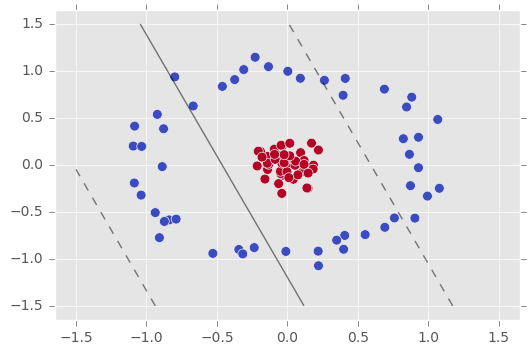

In [700]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
hiperplanos(clf)

El modelo lineal no acierta a separar correctamente ambas clases de puntos. La tasa de acierto conseguida es baja.  

El asunto es que el algoritmo de las *Support Vector Machines* emplea clasificadores lineales y, en cambio, un conjunto de datos complicado como este no se puede separar con un solo clasificador lineal. Podría intentarse separar combinando varios clasificadores lineales. Sin embargo, el procedimiento que se usa en SVM es diferente. Se convierte el problema en lineal transformando el conjunto de datos mediante una función no-lineal **$\Phi$** aplicada a las variables (*features*). En el nuevo espacio de variables ampliado el problema es separable linealmente. Se entrena entonces el modelo para conseguir el clasificador lineal y se vuelve a transformar con la inversa de la función, **$\Phi^{-1}$**, al espacio de partida, donde el clasificador se ve como no-lineal. El problema es encontrar la función apropiada que realice dicha transformación. Además, si la función es complicada, podría costar evaluarla y ocupar mucha memoria. 
Pero hay una salida a estas dificultades. Resulta que en el planteamiento **dual** del problema los puntos transformados solo aparecen como productos escalares **$\Phi(x_i)\cdot\Phi(x_j)$**. Así que se puede definir una función ** *kernel* **, **$k(x_i,x_j)=\Phi(x_i)\cdot\Phi(x_j)$**, de manera que no se necesite calcular ni conocer explícitamente siquiera la función **$\Phi$**. Esto es válido en el planteamiento dual, en el primal sí se necesita conocer **$\Phi$**.

Un ejemplo de función para un problema bidimensional (dos *features* **$x_1, x_2$** en el conjunto de datos) es $\Phi:\mathbf{ R^2}\rightarrow\mathbf{R^4}$ tal que:

In [515]:
%%latex
\[
(z_1,z_2,z_3,z_4)=\mathbf{\Phi(x)}=(x_1^3,x_2^3,\sqrt{3}x_1^2x_2,\sqrt{3}x_1x_2^2)
\]

<IPython.core.display.Latex object>

De forma que la función *kernel* queda:

In [524]:
%%latex
\begin{eqnarray}
    \mathbf{k(x,y)} & = &  \mathbf{\Phi(x)\cdot\Phi(y)}=\\
     & = & (x_1^3,x_2^3,\sqrt{3}x_1^2x_2,\sqrt{3}x_1x_2^2)\cdot\left(\begin{array}{l}
                                                             y_1^3\\
                                                              y_2^3\\
                                                              \sqrt{3}y_1^2y_2\\
                                                              \sqrt{3}y_1y_2^2
                                                             \end{array}
                                                             \right)=\\ \\
        & = & x_1^3y_1^3+3x_1^2y_1^2x_2y_2+3x_1y_1x_2^2y_2^2+x_2^3y_2^3=(x_1y_1+x_2y_2)^3=\\ \\
        & = & (\mathbf{x\cdot y})^3
\end{eqnarray}

<IPython.core.display.Latex object>

Es decir, que la función *kernel* es simplemente el cubo del producto escalar de las *features* de dos puntos. No hace falta conocer la función de transformación **$\Phi$**, sino sencillamente computar el producto escalar **$x\cdot y$**.  
Existe un teorema, el teorema de Mercer, que posibilita la construcción de funciones *kernel*. Voy a empezar probando un ** *kernel* gaussiano** RBF (Radial Basis Function), cuya expresión es:

In [533]:
%%latex
\[\mathbf{k(x_i,x_j)}=e^{-\gamma\|\mathbf{x_i-x_j}\|^2}\]

<IPython.core.display.Latex object>

La función gaussiana tiene forma de campana. Esto nos da una pista para separar las dos clases de puntos de nuestro problema, ya que puede considerarse que los puntos agrupados aproximadamente en el círculo interior que tenemos son una proyección sobre un plano de puntos situados en la parte superior de una campana de Gauss y los puntos situados en el círculo exterior son la proyección de puntos localizados en el lateral de la campana. Si pasamos del espacio bidimensional que tenemos (es decir, dos *features* **$x_1, x_2$**) a un espacio de tres dimensiones donde las dos primeras son las propias **$x_1, x_2$** y la tercera es la imagen de la función gaussiana, $z_3=e^{-(x_1^2+x_2^2)}$, se llega a una situación en la que las dos clases de puntos son inmediatamente separables linealmente mediante un plano horizontal, como puede apreciarse en la siguiente figura. La función de transformación sería $\Phi:\mathbf{ R^2}\rightarrow\mathbf{R^3}$ tal que:

In [706]:
%%latex
\(
(z_1,z_2,z_3)=\mathbf{\Phi(x)}=(x_1,x_2,e^{-(x_1^2+x_2^2)})
\)

<IPython.core.display.Latex object>

In [698]:
gauss= np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

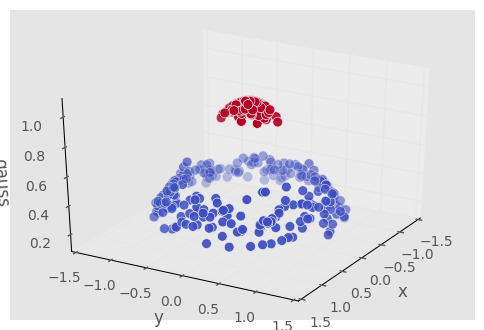

In [699]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], gauss, c=y, s=50, cmap='coolwarm')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('gauss')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180))

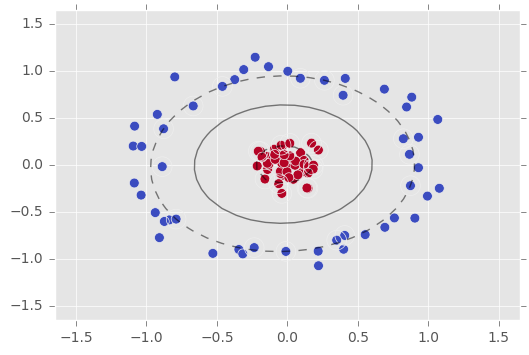

In [705]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
hiperplanos(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none')

Ajustando el modelo con este *kernel* y valores **$C=1, \gamma=0.01$** se obtiene un modelo que tiende ya al sobreajuste.

![SVM_NoLineal_RBF_C=1_g=0.01](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_C=1_g=0.01.png)

Si sigo aumentando el valor del parámetro del kernel, el *overfitting* es más acusado. Por ejemplo, para **$C=1, \gamma=0,09$**.

![SVM_NoLineal_RBF_C=1_g=0.09](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_C=1_g=0.09.png)

Se consigue un modelo más razonable on valores **$C=1$** y **$\gamma=0,001$**.

![SVM_NoLineal_RBF_C=1_g=0.001](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_C=1_g=0.001.png)

En cualquier caso, estos ejemplos no lineales son bastante sencillos de separar y se consigue una *accuracy* del 100%.

Otro tipo de función *kernel* empleada muy a menudo es el ** *kernel* polinómico**, cuya expresión es:

In [538]:
%%latex
\(\mathbf{k(x_i,x_j)}=(\gamma\,\mathbf{x_i\cdot x_j}+r)^d\)

<IPython.core.display.Latex object>

Donde $d$ es el grado del polinomio, $\gamma$ es el coeficiente de las variables y $r$ es el término independiente. Hay que ir probando valores de estos parámetros (y del parámetro de regularización $C$) para ver con cuáles se consigue mejor resultado.  
Al igual que se ha dicho para el *kernel* gaussiano, para el conjunto de datos que hemos construido gráficamente es fácil darse cuenta de que los círculos concéntricos en torno a los cuales están agrupadas aproximadamente las dos clases de puntos son como la proyección sobre un plano de las líneas de nivel de un paraboloide, esto es, de una función del tipo $f(x,y)=x^2+y^2$. Este hecho nos proporciona una pista de que el grado del *kernel* polinómico que se debería probar es **$d=2$**. Con esto ya se consigue fijar uno de los parámetros; quedaría variar los demás. Más en detalle, puedo transformar el conjunto de datos bidimensional (dos *features* **$x_1, x_2$**) de partida en un espacio tridimensional de tres *features* (**$z_1, z_2, z_3$**) mediante la función $\Phi:\mathbf{ R^2}\rightarrow\mathbf{R^3}$ tal que:

In [539]:
%%latex
\[
(z_1,z_2,z_3)=\mathbf{\Phi(x)}=(x_1,x_2,x_1^2+x_2^2)
\]

<IPython.core.display.Latex object>

In [707]:
parab= np.array((X[:, 0] ** 2 + X[:, 1] ** 2))

<function __main__.plot_3D>

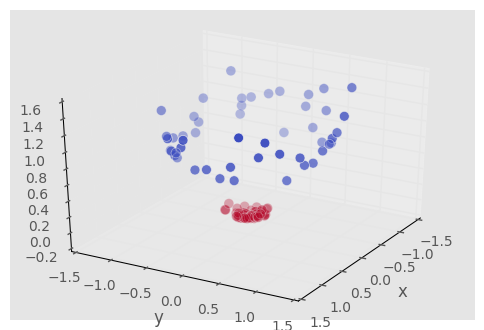

In [709]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], parab, c=y, s=50, cmap='coolwarm')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_zlabel('paraboloide')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180))

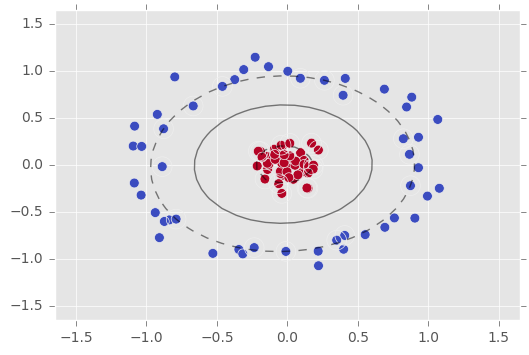

In [710]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
hiperplanos(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

En el nuevo espacio ampliado (de 3 dimensiones) las dos clases son separables linealmente. Hallo en él el clasificador lineal y vuelvo al espacio original (de 2 dimensiones) con la transformación inversa, tal como indica el siguiente diagrama (extraído de Python Machine Learning de Sebastian Raschka):

![Paraboloide](./Practica_AlgoritmosAvanzados_Pablo/Paraboloide.png)

Voy a probar en primer lugar grados **$d=1$** (corresponde al kernel lineal ya visto) y **$d=5$** con parámetro de regularización **$C=1$**. Debería obtener malos resultados en ambos casos.

![SVM_NoLineal_poly_C=0.01_d=1.png](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_C=1_d=1.png)
![SVM_NoLineal_poly_C=0.01_d=5.png](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_C=1_d=5.png)

Efectivamente, los resultados son muy malos; la *accuracy* no supera el 71%. Pruebo ahora grado dos (**$d=2$**) con parámetro de regularización **$C=1$**. Según lo expuesto anteriormente, el modelo ahora debería separar correctamente las dos clases.

![SVM_NoLineal_poly_C=1_d=2.png](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_C=1_d=2.png)

Como cabía esperar, la separación es correcta, obteniéndose una *accuracy* del 100% para este ejercicio académico.

# 2.3 Tuning SVM parameters
A continuación se van a comprobar los efectos de cambiar los valores de los diferentes parámetros. Se añaden al anillo exterior nuevos puntos de su clase y algunos de la clase contraria. Pruebo **$C=0.01$** y **$\gamma=0.01$** para *kernel* gaussiano.

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_PuntosMezclados_C=0.01_g=0.01.png)

El parámetro de regularización **$C$** conlleva un balance entre menor número de errores y modelo más sencillo (más sencillo implica más errores). Si se dan valores extremos a ese parámetro, se persigue un objetivo u otro. Para un valor pequeño como el elegido, 0.01, se da más importancia a la simplicidad del modelo y se llega a un modelo con **subajuste** (*underfitting*), representado en la figura superior (*accuracy* = 77,6%).  
Por el contrario, si se elige un valor grande, por ejemplo **$C=100$**, se hace hincapié en reducir el error. Se obtiene un modelo **sobreajustado** (*overfitting*) que no se amoldará bien a la incorporación de datos nuevos. Esta situación viene representada en la siguiente figura, en la que la línea sólida (el hiperplano de decisión) se ajusta excesivamente a todos los puntos blancos (*accuracy* = 100%). Si se introdujeran puntos nuevos, con mucha probabilidad quedarían mal separados en el lado equivocado del hiperplano de decisión.

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_PuntosMezclados_C=100_g=0.004.png)

Procedo ahora de igual manera para el parámetro del *kernel*. Elijo primero un valor pequeño, **$\gamma=0.0001$**, con un valor intermedio para el parámetro de regularización, **$C=1$**. 

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_PuntosMezclados_C=1_g=0.0001.png)

El parámetro **$\gamma$** se encuentra en el exponente del *kernel* gaussiano multiplicando a la distancia entre dos puntos del conjunto de datos. Mide, por tanto, la similitud de los puntos mediante su distancia en el espacio de las *features*. Además, como se encuentra en el exponente de una exponencial decreciente, controla la rapidez con la que la función *kernel* tiende a cero con la distancia.  
Con un valor muy pequeño como el elegido, la exponencial de la función *kernel* tiende a 1 ($e^0=1$), lo cual se traduce en una situación de subajuste. Con un valor grande, **$\gamma=0.05$** (con **$C=1$**), se tiene que la exponencial tiende a cero, lo que se corresponde con un modelo sobreajustado como el de la siguiente figura, con el hiperplano de decisión muy ajustado (*accuracy* = 100%).

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_PuntosMezclados_C=1_g=0.05.png)

Un modelo adecuado se obtiene con valores intermedios, por ejemplo **$C=2$** y **$\gamma=0,01$**. La tasa de clasificación correcta es del 93,4%.

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_RBF_PuntosMezclados_C=2_g=0.01.png)

## Polynomial kernel (Pro)
Voy a sintonizar ahora los parámetros correspondientes a un modelo con *kernel* polinómico. Recuérdese que su expresión viene dada por:

In [544]:
%%latex
\(\mathbf{k(x_i,x_j)}=(\gamma\,\mathbf{x_i\cdot x_j}+r)^d\)

<IPython.core.display.Latex object>

Según he motivado unos párrafos más arriba, hay razones para elegir grado 2. Así que fijo **$d=2$** para todos los ejemplos de este apartado. Pruebo con un término independiente $r=coef0=-10$. Escojo un parámetro de regularización intermedio, **$C=1$** y como coeficiente de las *features* elijo **$\gamma=0,1$**.

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_PuntosMezclados_d=2_coef=-10_C=1_g=0.1.png)

El modelo tiene una *accuracy* del 82.9%, no demasiado buena. Gráficamente el separador tiene forma de elipse, que es la proyección sobre el plano de una circunferencia inclinada. Es como si el término independiente introducido hubiera alterado la situación sencilla mostrada anteriormente en el diagrama del paraboloide haciendo que el hiperplano de decisión (que en dicho diagrama era horizontal) se incline de forma que corte al paraboloide oblicuamente por mal sitio.  
Pruebo ahora $r=0$, dejando los demás parámetros iguales.


![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_PuntosMezclados_d=2_coef=0_C=1_g=0.1.png)

La situación ha mejorado. El hiperplano de corte está más centrado. La *accuracy* se eleva a 93,4%. Voy a probar con $r=100$.

![SVM_NoLineal](./Practica_AlgoritmosAvanzados_Pablo/SVM_NoLineal_poly_PuntosMezclados_d=2_coef=100_C=1_g=0.1.png)

El hiperplano de decisión está más centrado, pero la situación difiere muy poco de la anterior. La tasa de acierto en la clasificación es la misma, 93.4%.

# 2.4 Real-world example: *thyroid*
A continuación, usando el conjunto de datos *thyroid*, se analiza el efecto que tiene sobre el porcentaje de aciertos el hecho de modificar el parámetro de regularización, C, y los kernels del modelo de SVM y sus parámetros.  
Se empieza con el **modelo lineal** probando varios valores de C (potencias de 10). Para ello genero un array con la función *logspace* y se lo paso al modelo mediante un bucle for.

In [53]:
"""
=========
SVM Train
=========

Trains an SVM model using some fixed parameters.
You can edit the configuration part of this file to
change the parameter values.
"""
from __future__ import division, print_function

# Author: Alvaro Barbero
#
# License: Free BSD
#
import numpy as np
import sys
from sklearn import svm
from scipy import io

### CONFIG: edit here to change model parameters ###

# Type of kernel. Kernels available: "linear", "poly", "rbf"
kernel = "linear"
# C regularization parameter
#C = 0.01
# RBF kernel width 
gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 11 valores de C en progresión geométrica (no aritmética), por ejemplo, de potencias de 10 desde 1E-4
    # hasta 1 000 000:
    C=np.logspace(-4,6,num=11,base=10) 
         
    for i in C:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
       
    # Print accuracy result
        print("C: %s, \t Accuracy: %s" %(i, acc))
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


C: 0.0001, 	 Accuracy: 66.1971830986
C: 0.001, 	 Accuracy: 66.1971830986
C: 0.01, 	 Accuracy: 66.1971830986
C: 0.1, 	 Accuracy: 83.0985915493
C: 1.0, 	 Accuracy: 88.7323943662
C: 10.0, 	 Accuracy: 87.323943662
C: 100.0, 	 Accuracy: 87.323943662
C: 1000.0, 	 Accuracy: 87.323943662
C: 10000.0, 	 Accuracy: 87.323943662
C: 100000.0, 	 Accuracy: 88.7323943662
C: 1000000.0, 	 Accuracy: 87.323943662


En esta inspección inicial de tan solo 11 valores se aprecia que para valores de C menores que 0.01 el porcentaje de aciertos no varía, al igual que para valores superiores a 1 aproximadamente (hay alguna pequeña fluctuación debido, probablemente, al algoritmo de iteración empleado por debajo).  
Una vez que nos hemos hecho una idea del rango de variación de la precisión con el parámetro de regularización C, tomo más valores (200) para poder representar la situación gráficamente. Para ello creo sendas listas con los valores de C y de la *accuracy*.

In [ ]:
C_out=[]
acc_out=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 200 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-4 hasta 1 000 000:
    C=np.logspace(-4,6,num=200,base=10) 
         
    for i in C:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out.append(i)
        acc_out.append(acc)
        
if __name__ == "__main__":
    main(sys.argv)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [16]:
plt.style.use("ggplot")

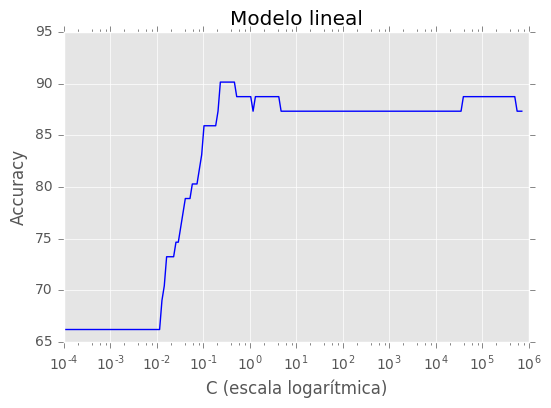

In [50]:
plt.semilogx(C_out, acc_out, 'b-', linewidth = 1)
plt.xlabel("C (escala logarítmica)")
plt.ylabel("Accuracy")
plt.title("Modelo lineal")
plt.grid("on")

En el gráfico anterior se aprecia claramente que el máximo valor de tasa de aciertos se obtiene para un valor de C de entre 0.2 y 0.5. Para localizarlo más exactamente hago un "zoom" en esa zona.

In [54]:
def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Me centro en valores de C entre 0.1 y 1:
    C=np.arange(0.1,1,0.05) 
         
    for i in C:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        
    # Print accuracy result
        print("C: %s, \t Accuracy: %s" %(i, acc))
        
if __name__ == "__main__":
    main(sys.argv)

C: 0.1, 	 Accuracy: 83.0985915493
C: 0.15, 	 Accuracy: 85.9154929577
C: 0.2, 	 Accuracy: 87.323943662
C: 0.25, 	 Accuracy: 90.1408450704
C: 0.3, 	 Accuracy: 90.1408450704
C: 0.35, 	 Accuracy: 90.1408450704
C: 0.4, 	 Accuracy: 90.1408450704
C: 0.45, 	 Accuracy: 88.7323943662
C: 0.5, 	 Accuracy: 90.1408450704
C: 0.55, 	 Accuracy: 88.7323943662
C: 0.6, 	 Accuracy: 88.7323943662
C: 0.65, 	 Accuracy: 88.7323943662
C: 0.7, 	 Accuracy: 88.7323943662
C: 0.75, 	 Accuracy: 88.7323943662
C: 0.8, 	 Accuracy: 88.7323943662
C: 0.85, 	 Accuracy: 88.7323943662
C: 0.9, 	 Accuracy: 88.7323943662
C: 0.95, 	 Accuracy: 88.7323943662


La máxima tasa de aciertos, **90.14**, se alcanza para varios valores de **C** como, por ejemplo, **0.3, 0.4 ó 0.5.**

Una vez analizado el modelo lineal paso a inspeccionar **modelos no lineales** con diferentes kernels, valores de sus parámetros y regularizaciones. Empiezo por el **kernel gaussiano** o Radial Basis Function (RBF). Hago un doble bucle for anidado para probar valores de C y gamma.

In [4]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    
    C=np.logspace(-3,4,num=8,base=10)
    gamma=np.logspace(-4,3,num=8,base=10)
        
   
    for i in C:
        for g in gamma:
    # Train model
            model = train(data['X'], data['y'],i,g)
    
    # Compute accuracy over test set
            acc = accuracy(model, data['Xtest'], data['ytest'])
    
    # Print accuracy result
            print("C: %s, \t gamma: %s,\t  Accuracy: %s" %(i, g, acc))
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i, g):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=g, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

C: 0.001, 	 gamma: 0.0001,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 0.001,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 0.01,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 0.1,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 1.0,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 10.0,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 100.0,	  Accuracy: 66.1971830986
C: 0.001, 	 gamma: 1000.0,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 0.0001,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 0.001,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 0.01,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 0.1,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 1.0,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 10.0,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 100.0,	  Accuracy: 66.1971830986
C: 0.01, 	 gamma: 1000.0,	  Accuracy: 66.1971830986
C: 0.1, 	 gamma: 0.0001,	  Accuracy: 66.1971830986
C: 0.1, 	 gamma: 0.001,	  Accuracy: 66.1971830986
C: 0.1, 	 gamma: 0.01,	  Accuracy: 66.1971830986
C: 0.1, 	 gamma: 0.1,	  Accuracy: 

Se aprecia que las mejores tasas de acierto se obtienen con valor de gamma=1. Para verlo más claramente voy a hacer varias gráficas, cada una para un valor de gamma distinto, variando en cada una el parámetro C entre 1E-3 y 10 000. Para cada gráfica genero valores de los ejes de ordenadas y abscisas.

In [5]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out1=[]
acc_out1=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C1=np.logspace(-3,4,num=100,base=10) 
         
    for i in C1:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out1.append(i)
        acc_out1.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=0.0001, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)



In [8]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out2=[]
acc_out2=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C2=np.logspace(-3,4,num=100,base=10) 
         
    for i in C2:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out2.append(i)
        acc_out2.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=0.001, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [9]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out3=[]
acc_out3=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C3=np.logspace(-3,4,num=100,base=10) 
         
    for i in C3:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out3.append(i)
        acc_out3.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=0.01, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [10]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out4=[]
acc_out4=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C4=np.logspace(-3,4,num=100,base=10) 
         
    for i in C4:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out4.append(i)
        acc_out4.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=0.1, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [11]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out5=[]
acc_out5=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C5=np.logspace(-3,4,num=100,base=10) 
         
    for i in C5:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out5.append(i)
        acc_out5.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=1, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [12]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out6=[]
acc_out6=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C6=np.logspace(-3,4,num=100,base=10) 
         
    for i in C6:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out6.append(i)
        acc_out6.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=10, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [13]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out7=[]
acc_out7=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C7=np.logspace(-3,4,num=100,base=10) 
         
    for i in C7:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out7.append(i)
        acc_out7.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=100, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


In [14]:
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

C_out8=[]
acc_out8=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    C8=np.logspace(-3,4,num=100,base=10) 
         
    for i in C8:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
        C_out8.append(i)
        acc_out8.append(acc)  

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=1000, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)


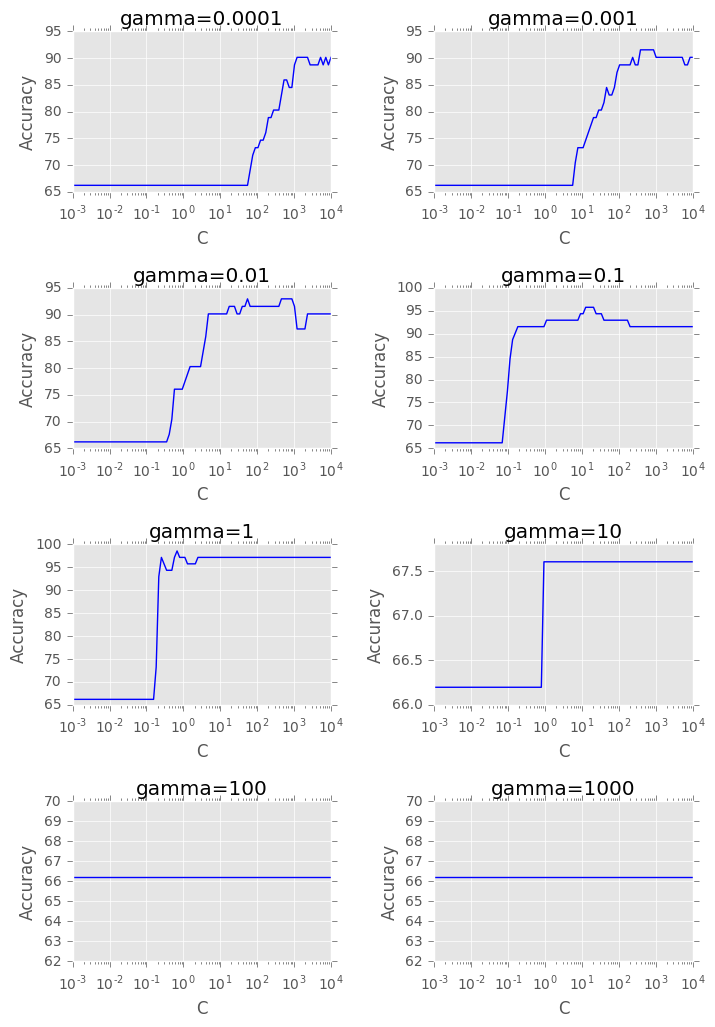

In [63]:
#plt.subplots_adjust(left  = 0.5)  # the left side of the subplots of the figure
#plt.subplots_adjust(right = 1.9)    # the right side of the subplots of the figure
#plt.subplots_adjust(bottom = 0.7)   # the bottom of the subplots of the figure
#plt.subplots_adjust(top = 0.9)      # the top of the subplots of the figure
#plt.subplots_adjust(wspace = 1.2)   # the amount of width reserved for blank space between subplots
#plt.subplots_adjust(hspace = 1.9)   # the amount of height reserved for white space between subplots

plt.figure(figsize=(8,12))

plt.subplots_adjust(hspace=0.6,wspace=0.4)

# log x axis
plt.subplot(4,2,1)
#plt.axes([0.2,0.55,3,3], axisbg = 'gray')
plt.semilogx(C_out1, acc_out1, 'b-', linewidth = 1)#,label="gamma=0.0001")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=0.0001")
#plt.legend()
plt.grid("on")

# log x axis
plt.subplot(4,2,2)
plt.semilogx(C_out2, acc_out2, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=0.001")
plt.grid("on")

# log x axis
plt.subplot(4,2,3)
plt.semilogx(C_out3, acc_out3, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=0.01")
plt.grid("on")

# 
plt.subplot(4,2,4)
plt.semilogx(C_out4, acc_out4, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=0.1")
plt.grid("on")

plt.subplot(4,2,5)
plt.semilogx(C_out5, acc_out5, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=1")
plt.grid("on")

plt.subplot(4,2,6)
plt.semilogx(C_out6, acc_out6, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=10")
plt.grid("on")

plt.subplot(4,2,7)
plt.semilogx(C_out7, acc_out7, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=100")
plt.grid("on")

plt.subplot(4,2,8)
plt.semilogx(C_out8, acc_out8, 'b-', linewidth = 1)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("gamma=1000")
plt.grid("on")

plt.show()

De las gráficas anteriores queda claro que los valores que optimizan la tasa de aciertos son gamma=1 con C entre 0.1 y 1. Voy a hacer una sintonía fina para afinar mejor el valor de regularización C.

In [66]:

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un array de 100 valores de C en progresión geométrica (no aritmética), por ejemplo desde 1E-3 hasta 10 000:
    Ct=np.linspace(0.1,1.1,num=21) 
         
    for i in Ct:
    # Train model
        model = train(data['X'], data['y'],i)
    
    # Compute accuracy over test set
        acc = accuracy(model, data['Xtest'], data['ytest'])
         
    # Print accuracy result
        print("C: %s,  \t gamma: %s,\t  Accuracy: %s" %(i, 1, acc))

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=1, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

C: 0.1,  	 gamma: 1,	  Accuracy: 66.1971830986
C: 0.15,  	 gamma: 1,	  Accuracy: 66.1971830986
C: 0.2,  	 gamma: 1,	  Accuracy: 81.6901408451
C: 0.25,  	 gamma: 1,	  Accuracy: 95.7746478873
C: 0.3,  	 gamma: 1,	  Accuracy: 95.7746478873
C: 0.35,  	 gamma: 1,	  Accuracy: 94.3661971831
C: 0.4,  	 gamma: 1,	  Accuracy: 94.3661971831
C: 0.45,  	 gamma: 1,	  Accuracy: 94.3661971831
C: 0.5,  	 gamma: 1,	  Accuracy: 95.7746478873
C: 0.55,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 0.6,  	 gamma: 1,	  Accuracy: 98.5915492958
C: 0.65,  	 gamma: 1,	  Accuracy: 98.5915492958
C: 0.7,  	 gamma: 1,	  Accuracy: 98.5915492958
C: 0.75,  	 gamma: 1,	  Accuracy: 98.5915492958
C: 0.8,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 0.85,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 0.9,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 0.95,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 1.0,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 1.05,  	 gamma: 1,	  Accuracy: 97.1830985915
C: 1.1,  	 gamma: 1,	  Accuracy: 97.1830985915


Concluyo que los mejores valores que se pueden obtener para el kernel gaussiano son **gamma= 1** y **C= 0.7**, que producen una tasa de acierto del **98.59%**.  
También puede representarse la situación en un gráfico tridimensional donde los ejes *x* e *y* son los parámetros C y gamma, respectivamente, y el eje *z* es el porcentaje de aciertos sobre el conjunto de test. 

In [178]:
C_out_prueba=[]
gamma_out_prueba=[]
acc_out_prueba=[]

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    
    C_prueba=np.linspace(0.1,1.1,num=21)
    gamma_prueba=np.linspace(0.1,1.1,num=21)
        
   
    for i in C_prueba:
        for g in gamma_prueba:
    # Train model
            model = train(data['X'], data['y'],i,g)
    
    # Compute accuracy over test set
            acc = accuracy(model, data['Xtest'], data['ytest'])
            C_out_prueba.append(i)
            gamma_out_prueba.append(g)
            acc_out_prueba.append(acc)

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i, g):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=g, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

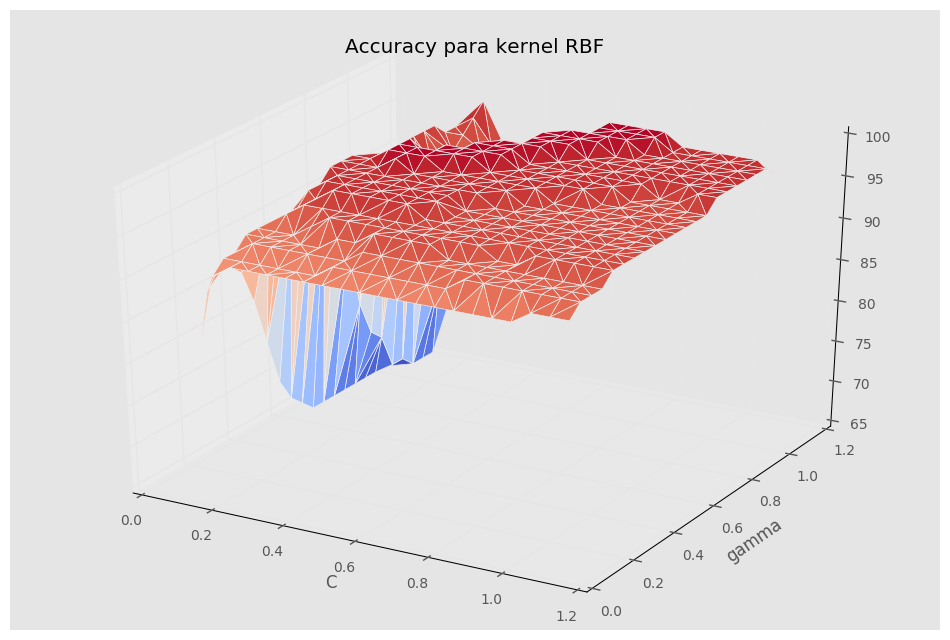

In [442]:
from mpl_toolkits.mplot3d import Axes3D         # Cargo Axes3D de mpl_toolkits.mplot3d
from scipy.misc import imread                   # Cargo imread de scipy.misc
#import numpy as np                              # Cargo numpy como el aliaas np
#import matplotlib.pyplot as plt                 # Cargo matplotlib.pyplot  en el alias sp

from matplotlib import cm                       # Cargo los mapas de colores


# Creo una figura y la almaceno en figura_3d


figura_3d = plt.figure(figsize=(12,8))

# Indicamos que vamos a representar en 3D
ax = figura_3d.gca(projection = '3d')

X_prueba = C_out_prueba
Y_prueba = gamma_out_prueba

#X_pruebaa, Y_pruebaa = np.meshgrid(X_prueba, Y_prueba)

Z_prueba = acc_out_prueba


##ax.plot_surface(X_pruebaa, Y_pruebaa, Z_prueba) #,  rstride=2, cstride=2)#, facecolors = np.flipud(imagen_superficial)
##ax.plot_wireframe(X_pruebaa, Y_pruebaa, Z_prueba, rstride=5, cstride=5)
ax.plot_trisurf(X_prueba, Y_prueba, Z_prueba,cmap=cm.coolwarm)

# Fijamos la posición inicial de la grafica
#ax.view_init(45, -35)

# Añadimos etiquetas
plt.title('Accuracy para kernel RBF')
plt.xlabel('C')
plt.ylabel('gamma')

# Mostramos en pantalla
plt.show()

A continuación realizo el mismo análisis para kernel **polinómico**. Llevo a cabo una primera inspección de la variación del porcentaje de acierto según los valores del parámetro de regularización C y el grado del kernel.  
*Nota. En realidad el modelo varía según otro parámetro, llamado gamma en el programa svm_gui.py, que multiplica al producto de las variables. Después de probar se comprueba que el mejor valor se 1.*

In [204]:
kernel = "poly"
# C regularization parameter
#C = 0.01
# RBF kernel width 
gamma = 1
# Polynomial kernel degree
#degree = 2
# Polynomial kernel zero coefficient
coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###
def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    
    C=np.logspace(-3,5,num=9,base=10)
    degree=np.arange(1,5)
        
   
    for d in degree:
        for i in C:
    # Train model
            model = train(data['X'], data['y'],i,d)
    
    # Compute accuracy over test set
            acc = accuracy(model, data['Xtest'], data['ytest'])
    
    # Print accuracy result
            print("C: %s, \t grado: %s,\t  Accuracy: %s" %(i, d, acc))
           # print("C: %s, \t   Accuracy: %s" %(i, acc))

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i,d):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=coef0, degree=d)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

C: 0.001, 	 grado: 1,	  Accuracy: 66.1971830986
C: 0.01, 	 grado: 1,	  Accuracy: 66.1971830986
C: 0.1, 	 grado: 1,	  Accuracy: 83.0985915493
C: 1.0, 	 grado: 1,	  Accuracy: 88.7323943662
C: 10.0, 	 grado: 1,	  Accuracy: 87.323943662
C: 100.0, 	 grado: 1,	  Accuracy: 87.323943662
C: 1000.0, 	 grado: 1,	  Accuracy: 87.323943662
C: 10000.0, 	 grado: 1,	  Accuracy: 87.323943662
C: 100000.0, 	 grado: 1,	  Accuracy: 88.7323943662
C: 0.001, 	 grado: 2,	  Accuracy: 77.4647887324
C: 0.01, 	 grado: 2,	  Accuracy: 90.1408450704
C: 0.1, 	 grado: 2,	  Accuracy: 91.5492957746
C: 1.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 10.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 100.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 1000.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 10000.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 100000.0, 	 grado: 2,	  Accuracy: 95.7746478873
C: 0.001, 	 grado: 3,	  Accuracy: 80.2816901408
C: 0.01, 	 grado: 3,	  Accuracy: 85.9154929577
C: 0.1, 	 grado: 3,	  Accuracy: 90.1408450704

Se aprecia que las mejores tasas de acierto se obtienen para un kernel polinómico de grado 2 para un amplio rango de valores del parámetro de regularización C. Una vez hallado el mejor valor del grado paso a localizar el mejor valor del parámetro coef0. Dejo que el parámetro de regularización varíe.

In [208]:
kernel = "poly"
# C regularization parameter
#C = 0.01
# RBF kernel width 
gamma = 1
# Polynomial kernel degree
degree = 2
# Polynomial kernel zero coefficient
#coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###
def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    
    C=np.logspace(-3,5,num=9,base=10)
    coef=np.linspace(-100,100,num=11)
        
   
    for r in coef:
        for i in C:
    # Train model
            model = train(data['X'], data['y'],i,r)
    
    # Compute accuracy over test set
            acc = accuracy(model, data['Xtest'], data['ytest'])
    
    # Print accuracy result
            print("C: %s, \t coef0: %s,\t  Accuracy: %s" %(i, r, acc))
           # print("C: %s, \t   Accuracy: %s" %(i, acc))

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i,r):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=r, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

C: 0.001, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 0.01, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 0.1, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 1.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 10.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 100.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 1000.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 10000.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 100000.0, 	 coef0: -100.0,	  Accuracy: 64.7887323944
C: 0.001, 	 coef0: -80.0,	  Accuracy: 67.6056338028
C: 0.01, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 0.1, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 1.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 10.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 100.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 1000.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 10000.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 100000.0, 	 coef0: -80.0,	  Accuracy: 64.7887323944
C: 0.001, 	 coef0: -60.0,	  Accuracy: 67.6056338028
C: 

Las mejores tasas de acierto se obtienen para coef0=0. Me centro ahora en torno a este valor por si se pudiera afinar más.

In [209]:
kernel = "poly"
# C regularization parameter
#C = 0.01
# RBF kernel width 
gamma = 1
# Polynomial kernel degree
degree = 2
# Polynomial kernel zero coefficient
#coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###
def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    
    C=np.logspace(-3,5,num=9,base=10)
    coef=np.linspace(-10,10,num=11)
        
   
    for r in coef:
        for i in C:
    # Train model
            model = train(data['X'], data['y'],i,r)
    
    # Compute accuracy over test set
            acc = accuracy(model, data['Xtest'], data['ytest'])
    
    # Print accuracy result
            print("C: %s, \t coef0: %s,\t  Accuracy: %s" %(i, r, acc))
           # print("C: %s, \t   Accuracy: %s" %(i, acc))

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i,r):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=r, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

C: 0.001, 	 coef0: -10.0,	  Accuracy: 71.8309859155
C: 0.01, 	 coef0: -10.0,	  Accuracy: 67.6056338028
C: 0.1, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 1.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 10.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 100.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 1000.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 10000.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 100000.0, 	 coef0: -10.0,	  Accuracy: 64.7887323944
C: 0.001, 	 coef0: -8.0,	  Accuracy: 74.6478873239
C: 0.01, 	 coef0: -8.0,	  Accuracy: 67.6056338028
C: 0.1, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 1.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 10.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 100.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 1000.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 10000.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 100000.0, 	 coef0: -8.0,	  Accuracy: 64.7887323944
C: 0.001, 	 coef0: -6.0,	  Accuracy: 76.0563380282
C: 0.01, 	 coef0: -6.0

Se concluye que los mejores valores que se pueden encontrar son **C= 1, degree= 2** y **coef0= 0**, para los que se obtiene un porcentaje de éxito del **95.77%**.

## Grid search
A continuación se va a analizar la tasa de acierto mediante el método *grid search*, que consiste en pasar al modelo a entrenar listados de los parámetros que tiene que explorar. Además, este procedimiento realiza validación cruzada, esto es, divide el conjunto de datos (X, y) en varios bloques y considera que uno de ellos es de test y los otros de entrenamiento. Ajusta y vuelve a realizar otra iteración dividiendo de nuevo el conjunto en el mismo número de bloques que anteriormente y así sucesivamente. Después hace la media de los resultados obtenidos en cada iteración.  
Nos centramos en el kernel gaussiano.

In [210]:
from sklearn.model_selection import GridSearchCV

In [296]:
svm_gs=GridSearchCV(estimator=svm.SVC(),
                   param_grid={"C": [0.1, 0.3, 0.5, 0.7, 1.0],
                                  "kernel": ["rbf"],
                                  #"degree": [2,3,4]},
                               "gamma":[0.01,0.1,1,5,10],
                              "tol": [0.001,0.0001]},
                      scoring="roc_auc", # esta opción del parámetro scoring es la que arroja mejor resultado.
                      cv=3,
                      verbose=1)

He elegido que se divida en 3 bloques el conjunto de entrenamiento (cv=3).  
Existen varias métricas para la evaluación de los modelos: *roc_auc, accuracy, precision, average_precision, recall, f1*, etc. Después de probar varias la que mejor resultado ofrece es *roc_auc*.

In [216]:
datos = io.loadmat(data_file)

Antes de entrenar el modelo exploro el conjunto de datos para ver su estructura.

In [217]:
type(datos)

dict

In [218]:
print(datos.keys())
print(datos.values())

dict_keys(['y', 'yval', '__version__', '__globals__', 'ytest', '__header__', 'Xtest', 'X', 'Xval'])
dict_values([array([[-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
   

In [219]:
for clave, valor in datos.items():
    print((clave,valor))

('y', array([[-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1]], dtype=int16))
('yval', array([[-1],
       [-1],
       [

In [220]:
len(datos['X'])

72

In [221]:
len(datos['Xtest'])

71

In [222]:
len(datos['Xval'])

72

In [223]:
print(len(datos['y']))
print(len(datos['ytest']))
print(len(datos['yval']))

72
71
72


In [224]:
type(datos['y'])

numpy.ndarray

In [226]:
datos['y'].shape

(72, 1)

La variable *target* a predecir es un array de dos dimensiones. Por eso hay que aplicarle el método ravel() para "aplanarla", es decir, para convertirla en un array unidimensional. Si no se hace así, da error.

In [297]:
 svm_gs.fit(datos['X'], datos['y'].ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 0.5, 0.7, 1.0], 'tol': [0.001, 0.0001], 'gamma': [0.01, 0.1, 1, 5, 10], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [298]:
svm_gs.best_score_

0.98188025210084029

Observo los parámetros del mejor modelo.

In [299]:
svm_gs.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Una vez que se ha determinado cuál es el mejor modelo, se va a entrenar de manera convencional (sin GridSearchCV) usando los mejores hiperparámetros obtenidos. Ahora ya no hay validación cruzada. Se pasa el conjunto de datos de entrenamiento (datos['X'], datos['y']) al completo para ajustar el modelo:

In [300]:
modelo_ganador=svm.SVC(C=1.0, 
                   cache_size=200, 
                   class_weight=None, 
                   coef0=0.0,
                   decision_function_shape=None, 
                   degree=3, 
                   gamma=1, 
                   kernel='rbf',
                   max_iter=-1, 
                   probability=False, 
                   random_state=None, 
                   shrinking=True,
                   tol=0.001, 
                   verbose=False)

In [303]:
modelo_ganador.fit(datos['X'], datos['y'].ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [328]:
diccio=modelo_ganador.get_params()

print(diccio["C"])
diccio

1.0


{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Una vez ajustado el modelo ganador, se valida con el conjunto de validación (datos['Xtest'],datos['ytest']). En este caso, como Gridsearch ha realizado validación cruzada con el subconjunto de entrenamiento, el subconjunto (datos['Xval'],datos['yval']) es redundante.

In [306]:
modelo_ganador.score(datos['Xtest'],datos['ytest'].ravel())

0.971830985915493

Se aprecia que los mejores valores de los parámetros arrojados por el proceso de grid search se asemejan a los obtenidos anteriormente de forma manual. Previamente se obtuvo **C= 0.7** y **gamma= 1**; ahora se ha obtenido **C= 1** y **gammma= 1**. La tasa de aciertos es inferior ahora, un **97.18%** frente al **98.59%** anterior.

## Función *tune*. Grid search (Pro)

In [341]:
from sklearn.svm import SVC

"""
=========
SVM Train
=========

Trains an SVM model using some fixed parameters.
You can edit the configuration part of this file to
change the parameter values.
""
from __future__ import division, print_function

# Author: Alvaro Barbero
#
# License: Free BSD
#
import numpy as np
import sys
from sklearn import svm
from scipy import io

### CONFIG: edit here to change model parameters ###
"""

# Type of kernel. Kernels available: "linear", "poly", "rbf"
kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
#degree = 3
# Polynomial kernel zero coefficient
#coef0 = 0
# Name of the dataset file to load
data_file = "data/thyroid.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un grid de  valores de C y gamma:

    C=[0.1, 0.3, 0.5, 0.7, 1.0]
    gamma=[0.01, 0.1, 1, 5, 10]
         

    # Train model
    model = tune(data['X'], data['y'],C,gamma)
    
    # Compute accuracy over test set
    acc = accuracy(model, data['Xtest'], data['ytest'])
       
    diccio=model.get_params()
    
    # Print accuracy result
    print("C: %s, \t gamma: %s, \t Accuracy: %s\t" %(diccio["C"], diccio["gamma"], acc))
    print("La lista completa de todos los parámetros del mejor modelo es:\t")
    print(diccio)
    

# Se sustituye la función train por la función tune.
"""
def train(X, y):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
"""

def tune(X,y,C,gamma):
    svm_gs_tune=GridSearchCV(estimator=SVC(),
                       param_grid={"C": C,
                                  "kernel": ["rbf"],
                                  #"degree": [2,3,4]},
                               "gamma":gamma},
                              
                      scoring="roc_auc", # esta opción del parámetro scoring es la que arroja mejor resultado.
                      cv=3,
                      verbose=1)

    svm_gs_tune.fit(X, y.ravel())
  
    modelo_ganador_tune=svm_gs_tune.best_estimator_
    modelo_ganador_tune.fit(X, y.ravel())
    return modelo_ganador_tune
    
# Returns the accuracy of the model for some given data
def accuracy(model, X, y):
    return model.score(X, y) * 100
    
if __name__ == "__main__":
    main(sys.argv)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
C: 1.0, 	 gamma: 1, 	 Accuracy: 97.1830985915	
La lista completa de todos los parámetros del mejor modelo es:	
('degree', 3)
('gamma', 1)
('tol', 0.001)
('random_state', None)
('coef0', 0.0)
('cache_size', 200)
('decision_function_shape', None)
('max_iter', -1)
('kernel', 'rbf')
('shrinking', True)
('verbose', False)
('C', 1.0)
('probability', False)
('class_weight', None)


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.9s finished


La función tune funciona perfectamente. Al pasarle el grid de valores de C y gamma, realiza tres iteraciones de validación cruzada (cv=3) para cada par de valores de C y gamma, esto es: 3 iteraciones x 5 valores de C x 5 valores de gamma = 75, tal como ha realizado la función según indica el verbose. La función entrena todas las posibilidades, se queda con la mejor y devuelve sus parámetros y precisión, que son exactamente los mismos que se habían obtenido manualmente: **C= 1**, **gammma= 1** y **accuracy= 97.18%**.

# Support Vector Regression
# 3.1 Linear SVR

A continuación se van a ver ejemplos de uso de Support Vector Machines para regresión. Empiezo dibujando un conjunto de datos situados aproximadamente en línea recta y ajusto con parámetros **$C= 1$** y **$\epsilon = 10$**. El coeficiente **$R^2 = 0.8793$**.

![SVR_Lineal](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=1_e=10.png)

Al igual que antes, **$C$** es el parámetro de regularización, mientras que **$\epsilon$** es un nuevo parámetro que regula la anchura del "tubo  de regresión", indicado por las dos líneas discontinuas, y que establece la cantidad de error de regresión aceptable en el modelo. La línea sólida es la recta de regresión resultante del modelo.  
Si se disminuye el parámetro **$\epsilon$**, el tubo se estrecha puesto que en este caso se están teniendo en cuenta casi todos los errores (desde los más pequeños hasta los mayores). Se corre el riesgo de caer en **sobreajuste** (*overfitting*): muchos de los datos proporcionados al modelo caen dentro del tubo, pero si se incorporasen nuevos puntos, caerían fuera con mucha probabilidad y el modelo no sería bueno para predecir datos futuros. Por ejemplo, para **$\epsilon = 3$**, manteniendo **$C= 1$** se tiene **$R^2 = 0.8963$**:

![SVR_Lineal_C=1_e=3](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=1_e=3.png)

El caso contrario, **subajuste** (*underfitting*), se tiene si se toma un valor alto de **$\epsilon$**, por ejemplo **$\epsilon=50$**. Se consigue un modelo muy pobre en el que no se tienen en cuenta ni errores pequeños ni grandes. Todos los valores caen dentro de la franja, pero no se predice ninguna tendencia. La línea sólida de regresión (y las discontinuas del tubo) se vuelve casi horizontal porque el modelo se queda simplemente con el bias (ordenada en el origen de la recta), que es el promedio de los valores, es decir, hace $y=b$, donde $b$ es el bias, y, por tanto, se obtiene una función constante (recta horizontal). Se obtiene un coeficiente **$R^2 = -0.00070$**.

![SVR_Lineal_C=1_e=20](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=1_e=50.png)

Para evitar ambos problemas una elección adecuada sería tomar un valor intermedio, por ejemplo **$\epsilon=20$** con **$C=1$**.

![SVR_Lineal_C=1_e=20](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=1_e=20.png)

Lógicamente el ángulo de inclinación de la recta es intermedio entre el primer ejemplo y el anterior (horizontal).

Por otro lado, también se tiene el parámetro de regularización **$C$**, que busca un equilibrio entre minimizar los errores del conjunto de datos y conseguir modelos más simples. Con un valor elevado de **$C$** se consiguen modelos más complejos y se tiende al sobreajuste. Con valores pequeños se da más importancia a la simplicidad del modelo y se llega al subajuste. Por ejemplo, para valores de **$C=0.001$** y **$C=0.0001$**, se obtiene, respectivamente **$R^2 = 0.3035$** y **$R^2 = 0.0368$**:

![SVR_Lineal_C=0.001_e=20](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=0.001_e=20.png)

![SVR_Lineal_C=0.001_e=20](./Practica_AlgoritmosAvanzados_Pablo/SVR_Lineal_C=0.0001_e=20.png)

Se aprecia claramente el subajuste (underfitting). Cuanto menor es el valor de **$C$**, más horizontal es la recta de regresión (mayor subajuste). Para valores elevados, superiores a **$C=1$**, como 10 ó 100 apenas se percibe cambio en la inclinación de la recta de tres gráficas más arriba (**$\epsilon=20$** y **$C=1$**).

# 3.2 Non-linear SVR

Paso ahora a analizar modelos no lineales con **kernel gaussiano** para un conjunto de datos que se ajustan aproximadamente a una sinusoidal.  
Empiezo usando parámetros **$C=10, \gamma=0.1$** y **$\epsilon=20$**. Se obtiene un mal modelo con **subajuste** (coeficiente de determinación **$R^2=0.6010$**) debido a que el ancho del tubo es demasiado grande. Por dentro el modelo no considera los errores situados entre los valores **$-\epsilon=-20$** y **$\epsilon=20$**, lo cual implica descartar muchos errores, simplificando el modelo excesivamente.

![SVR_NoLineal_RBF_C=10_g=0.1_e=20.png](./Practica_AlgoritmosAvanzados_Pablo/SVR_NoLineal_RBF_C=10_g=0.1_e=20_.png)

Ajusto los parámetros a **$C=50, \gamma=0.2$** y **$\epsilon=2$**. Obtengo un modelo sobreajustado (**$R^2=0.8630$**). En este caso el parámetro **$\epsilon$** es 10 veces menor que en el anterior, es decir, que la anchura del tubo es un orden menor en magnitud. Por tanto, se consideran tanto los errores pequeños como los grandes y el modelo se ajusta muy bien a los datos proporcionados. Sin embargo, si se incluyeran nuevos puntos, estos caerían fuera del estrecho tubo y el rendimiento del modelo disminuiría.

![SVR_NoLineal_RBF_C=50_g=0.2_e=2.png](./Practica_AlgoritmosAvanzados_Pablo/SVR_NoLineal_RBF_C=50_g=0.2_e=2.png)

Un ajuste adecuado (situación intermedia entre las dos anteriores) lo obtengo con **$C=100, \,\gamma=0.01$** y **$\,\epsilon=10$** (**$R^2=0.8400$**).

![SVR_NoLineal_RBF_C=100_g=0.01_e=10.png](./Practica_AlgoritmosAvanzados_Pablo/SVR_NoLineal_RBF_C=100_g=0.01_e=10.png)

# Real-world example: *wind*
A continuación voy a realizar una modificación del script svm_train.py para entrenar un modelo SVR usando el conjunto de datos *wind*. Comienzo variando los parámetros de regularización, **$C$**, del kernel, **$\gamma$**, y del tubo, **$\epsilon$**, para potencias de 10 entre 0.01 y 100. Lo hago mediante tres bucles for anidados.

In [390]:
from sklearn.svm import SVR

kernel = "rbf"
# C regularization parameter
#C = 0.01
# RBF kernel width 
#gamma = 0.01
# Polynomial kernel degree
degree = 3
# Polynomial kernel zero coefficient
coef0 = 0
#Anchura del tubo de regresión
#epsilon
# Name of the dataset file to load
archivo = "data/wind.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    viento = io.loadmat(archivo)
    
    
    C=np.logspace(-2,2,num=5,base=10)
    gamma=np.logspace(-2,2,num=5,base=10)
    epsilon=np.logspace(-2,2,num=5,base=10)
        
   
    for e in epsilon:
        for g in gamma:
            for i in C:
    # Train model
                modelo = train(viento['X'], viento['y'],i,g,e)
    
    # Compute accuracy over test set
                per = performance(modelo, viento['Xtest'], viento['ytest'])
    
    # Print accuracy result
                print("epsilon: %s, \t gamma: %s,\t C: %s,  \t R2: %s" %(e, g, i, per))
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i, g, e):
    # Create SVM model
    modelo = svm.SVR(kernel=kernel, C=i, gamma=g, epsilon=e, coef0=coef0, degree=degree)
    # Train model
    modelo.fit(X, y.ravel())
    # Return trained model
    return modelo
    
# Returns the accuracy of the model for some given data
def performance(modelo, X, y):
    return modelo.score(X, y)
    
if __name__ == "__main__":
    main(sys.argv)

epsilon: 0.01, 	 gamma: 0.01,	 C: 0.01,  	 R2: -0.0388267793346
epsilon: 0.01, 	 gamma: 0.01,	 C: 0.1,  	 R2: 0.49535934309
epsilon: 0.01, 	 gamma: 0.01,	 C: 1.0,  	 R2: 0.5760022739
epsilon: 0.01, 	 gamma: 0.01,	 C: 10.0,  	 R2: 0.559334033943
epsilon: 0.01, 	 gamma: 0.01,	 C: 100.0,  	 R2: 0.530152304489
epsilon: 0.01, 	 gamma: 0.1,	 C: 0.01,  	 R2: 0.485096105362
epsilon: 0.01, 	 gamma: 0.1,	 C: 0.1,  	 R2: 0.590428264592
epsilon: 0.01, 	 gamma: 0.1,	 C: 1.0,  	 R2: 0.585929816939
epsilon: 0.01, 	 gamma: 0.1,	 C: 10.0,  	 R2: 0.599000367765
epsilon: 0.01, 	 gamma: 0.1,	 C: 100.0,  	 R2: 0.596947682458
epsilon: 0.01, 	 gamma: 1.0,	 C: 0.01,  	 R2: 0.612577749081
epsilon: 0.01, 	 gamma: 1.0,	 C: 0.1,  	 R2: 0.599096106515
epsilon: 0.01, 	 gamma: 1.0,	 C: 1.0,  	 R2: 0.595239796389
epsilon: 0.01, 	 gamma: 1.0,	 C: 10.0,  	 R2: 0.598521552575
epsilon: 0.01, 	 gamma: 1.0,	 C: 100.0,  	 R2: 0.598661553263
epsilon: 0.01, 	 gamma: 10.0,	 C: 0.01,  	 R2: 0.485952163047
epsilon: 0.01, 	 gamma

Se pueden descartar de entrada las potencias 10 y 100 para **$\epsilon$** porque con ellas se obtiene un coeficiente de determinación incluso negativo. Los valores de **$\gamma=100$** y **$C=100$** también arrojan un resultado inferior al producido por otros valores. Así que vuelvo a explorar valores reduciendo su rango de variación. 

In [391]:

kernel = "rbf"

# Name of the dataset file to load
archivo = "data/wind.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    vientos = io.loadmat(archivo)
    
    
    C=[0.01,0.1,1,10,50]
    gamma=[0.1,1,10,50]
    epsilon=[0.01,0.05,0.1,0.5,1]
        
   
    for e in epsilon:
        for g in gamma:
            for i in C:
    # Train model
                modelo = train(vientos['X'], vientos['y'],i,g,e)
    
    # Compute accuracy over test set
                per = performance(modelo, vientos['Xtest'], vientos['ytest'])
    
    # Print accuracy result
                print("epsilon: %s, \t gamma: %s,\t C: %s,  \t R2: %s" %(e, g, i, per))
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, y, i, g, e):
    # Create SVM model
    modelo = svm.SVR(kernel=kernel, C=i, gamma=g, epsilon=e, coef0=coef0, degree=degree)
    # Train model
    modelo.fit(X, y.ravel())
    # Return trained model
    return modelo
    
# Returns the accuracy of the model for some given data
def performance(modelo, X, y):
    return modelo.score(X, y)
    
if __name__ == "__main__":
    main(sys.argv)

epsilon: 0.01, 	 gamma: 0.1,	 C: 0.01,  	 R2: 0.485096105362
epsilon: 0.01, 	 gamma: 0.1,	 C: 0.1,  	 R2: 0.590428264592
epsilon: 0.01, 	 gamma: 0.1,	 C: 1,  	 R2: 0.585929816939
epsilon: 0.01, 	 gamma: 0.1,	 C: 10,  	 R2: 0.599000367765
epsilon: 0.01, 	 gamma: 0.1,	 C: 50,  	 R2: 0.597318294414
epsilon: 0.01, 	 gamma: 1,	 C: 0.01,  	 R2: 0.612577749081
epsilon: 0.01, 	 gamma: 1,	 C: 0.1,  	 R2: 0.599096106515
epsilon: 0.01, 	 gamma: 1,	 C: 1,  	 R2: 0.595239796389
epsilon: 0.01, 	 gamma: 1,	 C: 10,  	 R2: 0.598521552575
epsilon: 0.01, 	 gamma: 1,	 C: 50,  	 R2: 0.598669923412
epsilon: 0.01, 	 gamma: 10,	 C: 0.01,  	 R2: 0.485952163047
epsilon: 0.01, 	 gamma: 10,	 C: 0.1,  	 R2: 0.613666421056
epsilon: 0.01, 	 gamma: 10,	 C: 1,  	 R2: 0.606177727972
epsilon: 0.01, 	 gamma: 10,	 C: 10,  	 R2: 0.602617325254
epsilon: 0.01, 	 gamma: 10,	 C: 50,  	 R2: 0.600928850612
epsilon: 0.01, 	 gamma: 50,	 C: 0.01,  	 R2: 0.156353415866
epsilon: 0.01, 	 gamma: 50,	 C: 0.1,  	 R2: 0.579090741343
epsil

El mejor modelo presenta un coeficiente de determinación **$R^2=0.6138$** con parámetros **$\gamma=10, C=0.1$** y **$\epsilon=0.05$**.  
A continuación vuelvo a hacer lo mismo pero de manera automática definiendo una función llamada *tune*.

## Función *tune*. Grid search (Pro)

In [392]:
kernel = "rbf"

# Name of the dataset file to load
data_file = "data/wind.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    data = io.loadmat(data_file)
    
    # Genero un grid de  valores de C y gamma:

    C=[0.01,0.1,1,10,50]
    gamma=[0.1,1,10,50]
    epsilon=[0.01,0.05,0.1,0.5,1]
         

    # Train model
    model = tune(data['X'], data['y'],C,gamma,epsilon)
    
    # Compute accuracy over test set
    per = performance(model, data['Xtest'], data['ytest'])
       
    diccio=model.get_params()
    
    # Print accuracy result
    print("C: %s,   \t gamma: %s, \t epsilon: %s,  \t R2: %s\t" %(diccio["C"], diccio["gamma"], diccio["epsilon"], per))
    print("La lista completa de todos los parámetros del mejor modelo es:\t")
    print(diccio)
    

# Se sustituye la función train por la función tune.
"""
def train(X, y):
    # Create SVM model
    model = svm.SVC(kernel=kernel, C=i, gamma=gamma, coef0=coef0, degree=degree)
    # Train model
    model.fit(X, y.ravel())
    # Return trained model
    return model
"""

def tune(X,y,C,gamma,epsilon):
    svr_gs_tune=GridSearchCV(estimator=SVR(),
                       param_grid={"C": C,
                                   "kernel": ["rbf"],
                                  #"degree": [2,3,4]},
                                   "gamma":gamma,
                                   "epsilon":epsilon},
                              
                      verbose=1)

    svr_gs_tune.fit(X, y.ravel())
  
    modelo_ganador_tune=svr_gs_tune.best_estimator_
    modelo_ganador_tune.fit(X, y.ravel())
    return modelo_ganador_tune
    
# Returns the performance (R2) of the model for some given data
def performance(model, X, y):
    return model.score(X, y)
    
if __name__ == "__main__":
    main(sys.argv)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 20.3min finished


C: 0.1,   	 gamma: 10, 	 epsilon: 0.05,  	 R2: 0.613819995092	
La lista completa de todos los parámetros del mejor modelo es:	
{'degree': 3, 'epsilon': 0.05, 'verbose': False, 'gamma': 10, 'coef0': 0.0, 'shrinking': True, 'C': 0.1, 'cache_size': 200, 'tol': 0.001, 'max_iter': -1, 'kernel': 'rbf'}


Como era de esperar el mejor modelo encontrado mediante grid search con la función tune es el mismo que el obtenido manualmente: un coeficiente de determinación **$R^2=0.6138$** con parámetros **$\gamma=10, C=0.1$** y **$\epsilon=0.05$**.   

# 4. One-class SVM

Por último se van a aplicar modelos SVM no lineales al estudio de conjuntos formados por una sola clase para detectar *outliers*. Se trata de un caso de aprendizaje automático no supervisado porque ahora no se dispone de una variable *target* que indique el resultado (todos los puntos del conjunto de datos tienen la misma etiqueta).  
Se usará kernel gaussiano. Empiezo con valores de los parámetros **$\nu=0,5$** y **$\gamma=0,001$**.

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.5_g=0.001.png)

Si se aumenta el valor de **$\nu$** acercándolo a 1, la frontera de decisión (línea sólida) se encoge, es decir, se acerca más al centro de la nube de puntos y, por tanto, el área encerrada por ella (llamada *support* de la distribución) será muy pequeña y la mayoría de los puntos quedarán fuera como *outliers*. El modelo es muy malo. Elijo **$\nu=0,9$** y **$\gamma=0,001$**

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.9_g=0.001.png)

Por el contrario, para un valor de **$\nu$** cercano a cero el área de soporte (*support*) de la distribución aumentará mucho englobando casi todos los puntos y el modelo será muy poco sensible a los *outliers*, por lo que no será útil para detectarlos. Elijo **$\nu=0,2$** y **$\gamma=0,001$**.

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.2_g=0.001.png)

Se cumple que $0\leq$ fracción de errores $\leq\nu\leq$ fracción de SVs $\leq 1$. Gráficamente esto significa que los vectores de soporte (SV) solo pueden ser puntos situados sobre la frontera de decisión (línea sólida) o en el lado erróneo, es decir, fuera de ella. Si $\nu$ se aproxima a 1, la fracción de puntos que son SV es alta, esto es, la frontera de decisión se desplaza hacia el centro de la distribución de puntos y todos los que quedan fuera, la mayoría, actúan de SVs. Mientras que si *$\nu$* se aproxima a cero, la situación es la contraria: la frontera se desplaza hacia el exterior y muy pocos puntos quedan fuera del área de soporte y, por tanto, pocos son los puntos que actúan de SVs, tal como se ve en las dos gráficas anteriores.  

A continuación se incorporan al modelo unos puntos extremos (*outliers*) y se elige un valor $\nu=0.4$ (con $\gamma=0.001$) para que los deje fuera y capture la mayoría de los puntos centrales.

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.4_g=0.001.png)

Ya he elegido $\nu$. Ahora voy a modificar el valor del parámetro $\gamma$ del kernel gaussiano para ver cómo influye en el modelo. Un valor sensiblemente mayor que el anterior provocará una frontera de decisión muy complicada (sobreajuste), por ejemplo **$\gamma=0,02$**.

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.4_g=0.02.png)

Mientras que un valor muy pequeño, por ejemplo **$\gamma=0.0001$**, produce una frontera de decisión muy simple (elipse), es decir, una tendencia al subajuste.

![OneClass](./Practica_AlgoritmosAvanzados_Pablo/OneClass_RBF_nu=0.4_g=0.0001.png)

# Real-world example: *sonar*
A continuación voy a realizar una modificación del script svm_train.py para entrenar un modelo SVM One-class usando el conjunto de datos *sonar*. Comienzo inspeccionando la estructura del conjunto de datos proporcionado.

In [400]:
crudo=io.loadmat("data/sonar.mat")

In [401]:
type(crudo)

dict

In [403]:
crudo.keys()

dict_keys(['y', 'yval', '__version__', '__globals__', 'ytest', '__header__', 'Xtest', 'X', 'Xval'])

In [405]:
print(len(crudo['X']))
print(len(crudo['Xtest']))
print(len(crudo['Xval']))
print(len(crudo['y']))
print(len(crudo['ytest']))
print(len(crudo['yval']))

70
38
50
70
38
50


In [409]:
print(crudo['ytest'])

[[ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]]


In [417]:
for clave, valor in crudo.items():
    print((clave,valor))

('y', array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8))
('yval', array([[ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],


Como se trata de un caso de aprendizaje no supervisado, todas las etiquetas del conjunto de entrenamiento toman el valor 1. No así en el conjunto de test, puesto que habrá puntos que caigan fuera de la frontera de decisión. Por tanto, algunos de ellos tienen etiqueta igual a -1.  

Voy a entrenar manualmente un modelo de la clase OneClassSVM antes de pasar a hacerlo de manera automatizada para comprobar que funciona correctamente. La clase OneClassSVM no dispone de método *score()* por tratarse de aprendizaje no supervisado; así que uso el método *predict()* después de entrenar el modelo para obtener las etiquetas predichas (y_predicho) y comparo las predicciones con la label real (ytest) mediante *accuracy_score()*.

In [418]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score

In [412]:
mod = OneClassSVM(kernel=kernel, gamma=0.01, nu=0.5)
mod.fit(crudo['X'])
predicho=mod.predict(crudo['Xtest'])
predicho

array([ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.])

In [426]:
print(crudo['ytest'].shape)
print(predicho.shape)

(38, 1)
(38,)


La label ytest proporcionada y el resultado de aplicar el método *predict()* al modelo son arrays que no tienen exactamente las mismas dimensiones. Compruebo que ambos formatos son compatibles para ser comparados por *accuracy_score*.

In [425]:
predicho[0]==crudo['ytest'][0]

array([ True], dtype=bool)

In [414]:
accuracy_score(crudo['ytest'],predicho)*100

57.894736842105267

Funciona correctamente. A continuación, varío los parámetros del kernel, **$\gamma$**, y de la frontera, **$\nu$**.

In [421]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score

kernel = "rbf"

# RBF kernel width 
#gamma = 0.01

# Name of the dataset file to load
arch = "data/sonar.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    sonar = io.loadmat(arch)
    
    
    gamma=np.logspace(-3,2,num=6,base=10)
    nu=np.arange(0.1,1,0.1)
       
   

    for g in gamma:
        for i in nu:
    # Train model.
                modeloo = train(sonar['X'], g,i) # No hay label y puesto que es aprendizaje no supervisado.
    
    # Compute accuracy over test set
                acc = accuracy(modeloo, sonar['Xtest'], sonar['ytest'])
    
    # Print accuracy result
                print("gamma: %s, \t nu: %s,  \t Accuracy: %s" %(g, i, acc))
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, g, i):
    # Create SVM model
    modeloo = OneClassSVM(kernel=kernel, gamma=g, nu=i)
    # Train model
    modeloo.fit(X)
    # Return trained model
    return modeloo
    
# Returns the accuracy of the model for some given data
def accuracy(modeloo, X, y):
    ytest_predicho=modeloo.predict(X)
    return accuracy_score(ytest_predicho, y)*100
    
if __name__ == "__main__":
    main(sys.argv)

gamma: 0.001, 	 nu: 0.1,  	 Accuracy: 47.3684210526
gamma: 0.001, 	 nu: 0.2,  	 Accuracy: 50.0
gamma: 0.001, 	 nu: 0.3,  	 Accuracy: 55.2631578947
gamma: 0.001, 	 nu: 0.4,  	 Accuracy: 55.2631578947
gamma: 0.001, 	 nu: 0.5,  	 Accuracy: 60.5263157895
gamma: 0.001, 	 nu: 0.6,  	 Accuracy: 68.4210526316
gamma: 0.001, 	 nu: 0.7,  	 Accuracy: 65.7894736842
gamma: 0.001, 	 nu: 0.8,  	 Accuracy: 65.7894736842
gamma: 0.001, 	 nu: 0.9,  	 Accuracy: 63.1578947368
gamma: 0.01, 	 nu: 0.1,  	 Accuracy: 50.0
gamma: 0.01, 	 nu: 0.2,  	 Accuracy: 50.0
gamma: 0.01, 	 nu: 0.3,  	 Accuracy: 55.2631578947
gamma: 0.01, 	 nu: 0.4,  	 Accuracy: 57.8947368421
gamma: 0.01, 	 nu: 0.5,  	 Accuracy: 57.8947368421
gamma: 0.01, 	 nu: 0.6,  	 Accuracy: 68.4210526316
gamma: 0.01, 	 nu: 0.7,  	 Accuracy: 65.7894736842
gamma: 0.01, 	 nu: 0.8,  	 Accuracy: 68.4210526316
gamma: 0.01, 	 nu: 0.9,  	 Accuracy: 63.1578947368
gamma: 0.1, 	 nu: 0.1,  	 Accuracy: 50.0
gamma: 0.1, 	 nu: 0.2,  	 Accuracy: 50.0
gamma: 0.1, 	 nu: 

Los mejores parámetros encontrados son **$\gamma=1$** y **$\nu=0.1$**, para los que se obtiene una precisión del **73.68%**. 
Voy a representarlo gráficamente para tener una intuición más visual.

In [436]:
nu_one=[]
gamma_one=[]
acc_one=[]

data_file="data/sonar.mat"

kernel="rbf"

def main(argv):
    # Load dataset
    sonar = io.loadmat(data_file)
    
    
    nu=np.arange(0.1,1.1,0.1)
    gamma=np.linspace(0.01,2.01,num=101)
        
   
    for g in gamma:
        for n in nu:
    # Train model.
             modeloo = train(sonar['X'], g,n) # No hay label y puesto que es aprendizaje no supervisado.
    
    # Compute accuracy over test set
             acc = accuracy(modeloo, sonar['Xtest'], sonar['ytest'])
    
    # Print accuracy result
             nu_one.append(n)
             gamma_one.append(g)
             acc_one.append(acc)
        

# Trains an SVM model with the given data and the configuration parameters
def train(X, g, n):
    # Create SVM model
    modeloo = OneClassSVM(kernel=kernel, gamma=g, nu=n)
    # Train model
    modeloo.fit(X)
    # Return trained model
    return modeloo
    
# Returns the accuracy of the model for some given data
def accuracy(modeloo, X, y):
    ytest_predicho=modeloo.predict(X)
    return accuracy_score(ytest_predicho, y)*100
    
if __name__ == "__main__":
    main(sys.argv)

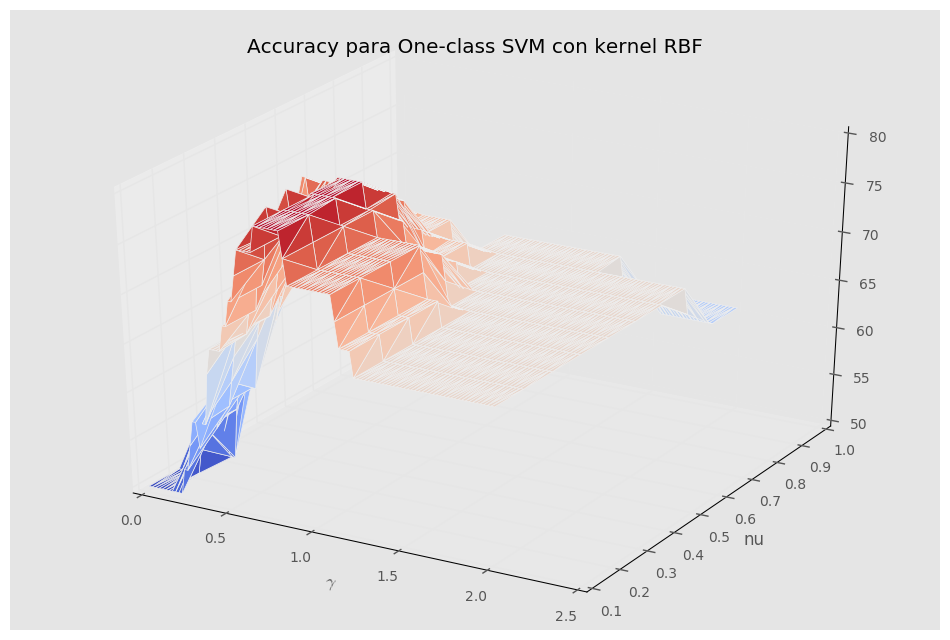

In [454]:
figuraa = plt.figure(figsize=(12,8))

# Indicamos que vamos a representar en 3D
ejess = figuraa.gca(projection = '3d')

X=gamma_one
Y=nu_one

#XX, YY = np.meshgrid(X, Y)

Z = acc_one


##ax.plot_surface(X_pruebaa, Y_pruebaa, Z_prueba) #,  rstride=2, cstride=2)#, facecolors = np.flipud(imagen_superficial)
##ax.plot_wireframe(X_pruebaa, Y_pruebaa, Z_prueba, rstride=5, cstride=5)
ejess.plot_trisurf(X, Y, Z,cmap=cm.coolwarm)

# Fijamos la posición inicial de la grafica
#ax.view_init(45, -35)

# Añadimos etiquetas
plt.title('Accuracy para One-class SVM con kernel RBF')
plt.xlabel('$\gamma$')
plt.ylabel('nu')

# Mostramos en pantalla
plt.show()

## Función *tune* (Pro)
Defino una función a la que paso una lista de valores de los parámetros **$\gamma$** y **$\nu$** y me devuelve la *accuracy* y los parámetros del mejor modelo.  
Como estamos en aprendizaje no supervisado, no tiene sentido la función GridSearchCV puesto que la clase OneClassSVM no dispone de un método *score()* como en los casos anteriores y, por tanto, no puede decidir. Lo implemento mediante bucles for y un condicional con break. El script va entrenando todos los modelos y guarda los parámetros y precisiones de cada uno de ellos en las variables params_one y acc_one. Después halla el máximo valor de *accuracy* e imprime los parámetros del modelo correspondiente.


In [476]:
kernel = "rbf"

# Name of the dataset file to load
data_file = "data/sonar.mat"

### CONFIG END ###

def main(argv):
    # Load dataset
    sonar = io.loadmat(data_file)
    
    # Genero un grid de  valores de C y gamma:

   
    gamma=[0.01,0.1,1,2]
    nu=[0.1,0.3,0.5,0.8]
    
    gamma_one=[]
    nu_one=[]
    acc_one=[]
    params_one=[]
         
    for g in gamma:
        for n in nu:
    # Train model.
            modelo = tune(sonar['X'], g,n) # No hay label y puesto que es aprendizaje no supervisado.
    
    # Compute accuracy over test set
            acc = accuracy(modelo, sonar['Xtest'], sonar['ytest'])
    
            params_one.append(modelo.get_params())
            nu_one.append(n)
            gamma_one.append(g)
            acc_one.append(acc)
    
    maximo=max(acc_one)
    for i in range(0,len(params_one)):
        if(acc_one[i] == maximo):
            break
    
    # Imprime el mejor resultado
    
    
    print("gamma: %s, \t nu: %s,  \t Accuracy: %s\t" %(gamma_one[i], nu_one[i], acc_one[i]))
    print("La lista completa de todos los parámetros del mejor modelo es:\t")
    print(params_one[i])
        

# Trains an SVM model with the given data and the configuration parameters
def tune(X, g, n):
    # Create SVM model
    modelo = OneClassSVM(kernel=kernel, gamma=g, nu=n)
    # Train model
    modelo.fit(X)
    
    # Return trained model
    return modelo
    
# Returns the accuracy of the model for some given data
def accuracy(modelo, X, y):
    ytest_predicho=modelo.predict(X)
    return accuracy_score(ytest_predicho, y)*100
    
if __name__ == "__main__":
    main(sys.argv)

gamma: 1, 	 nu: 0.1,  	 Accuracy: 73.6842105263	
La lista completa de todos los parámetros del mejor modelo es:	
{'degree': 3, 'gamma': 1, 'verbose': False, 'shrinking': True, 'random_state': None, 'nu': 0.1, 'coef0': 0.0, 'cache_size': 200, 'tol': 0.001, 'max_iter': -1, 'kernel': 'rbf'}


Como se puede ver, el modelo obtenido es el mismo de antes: parámetros **$\gamma=1$** y **$\nu=0.1$**, para los que se obtiene una precisión del **73.68%**